## Helio Inaba - CQF June 2023 Final Project 
## Optimal Hedging with Advanced Delta Modelling

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.optimize import minimize


from datetime import datetime
import os

#pd.set_option('display.max_columns', None)
pd.reset_option('^display.', silent=True)


#### Defining Functions

In [2]:
def gaussian(data, bins):
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))


def black_scholes(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(d2)

    V = n_d1*S-n_d2*K*np.exp(-r*T)
    
    return V


def bs_delta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    n_d1 = norm.cdf(d1)
    
    return n_d1


def bs_gamma(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def bs_vega(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return S*norm.pdf(d1)*np.sqrt(T)


def bs_theta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))
    theta -= r*K*np.exp(-r*T)*n_d2

    return theta

def bs_rho(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    return K*T*np.exp(-r*T)*n_d2


def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z_minus)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)

    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus


def fill_bridge_array(a, b, delta_t, z=None):
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt


def call_price(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_milstein(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path =  milstein(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_anti(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_plus, prices_minus = antithetic_variables(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = .5*(np.maximum(prices_plus.iloc[-1]-strike_E,0)+np.maximum(prices_minus.iloc[-1]-strike_E,0))
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_sobol(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = sobol_prices(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)

    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            payoff*np.exp(-risk_free*(expiry_T))]

### Part I: Volatility Arb with improved GBM and Monte-Carlo ###

1. Consider improvements to GBM asset evolution (Euler-Maruyana/Milstein schemes). <br> Optionally, can consider modelling asset with jumps, eg, Merton jump diffusion, without going into stochastic volatility, eg Heston-Nandi. <br> Variance Gamma is also relevant but suited for single-name assets with extreme movements.
 - consider MC variance reduction techniques, such as antithetic variates; <br>
 - best practice is low discrepancy sequences, eg Sobol with the Brownian bridge.


#### Defining Constants

In [755]:
df_mc_errors

,Euler_Maruyama,Milstein,Antithetic,Sobol_Brownian_Bridge
0,-22.144940,6.065514,4.794488,6.065514
1,-11.527382,6.065514,-0.998713,4.673972
2,-5.663083,6.065514,1.166051,1.299830
3,-2.730934,3.479517,-2.107848,2.491251
4,-0.971644,-0.112523,-1.755580,3.206104
...,...,...,...,...
262139,0.020301,0.005515,-0.007302,-0.000007
262140,0.020224,0.005536,-0.007316,0.000016
262141,0.020231,0.005530,-0.007345,-0.000005
262142,0.020237,0.005553,-0.007325,0.000008


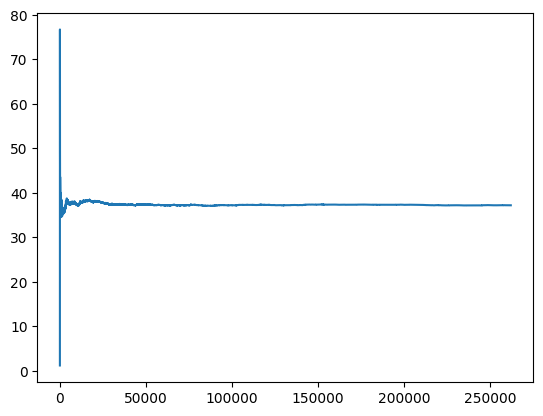

In [764]:
plt.plot(antithetic_option_prices.expanding().var())

In [ ]:
plt.plot(sobol_option_prices.expanding().var())

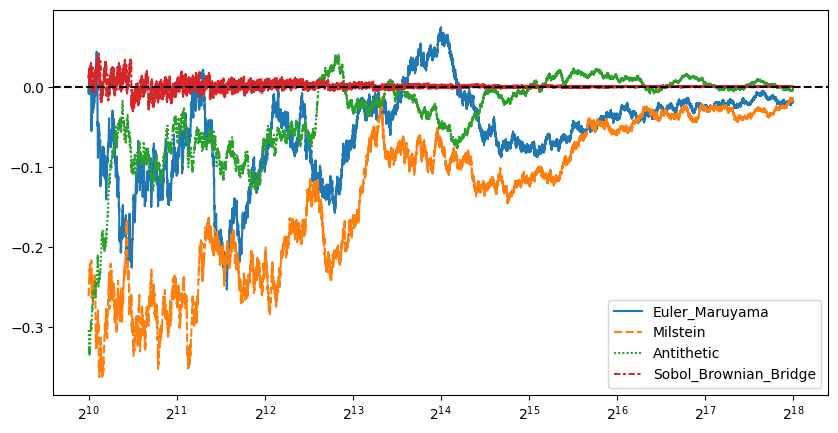

Euler_Maruyama          -0.019189
Milstein                -0.015054
Antithetic              -0.002409
Sobol_Brownian_Bridge   -0.000025
Name: 262143, dtype: float64


In [765]:
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

bs_price = black_scholes(S, K, sigma, T, r)

df_mc_errors = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_Brownian_Bridge'])
df_mc_variances = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_Brownian_Bridge'])

n_simulations = 2**18
n_periods = 2**9

euler_maruyama_option_prices = pd.Series(call_price(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1])
milstein_option_prices = pd.Series(call_price_milstein(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1])
antithetic_option_prices = pd.Series(call_price_anti(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1])
sobol_option_prices = call_price_sobol(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]

df_mc_errors['Euler_Maruyama'] = bs_price - euler_maruyama_option_prices.expanding().mean()
df_mc_errors['Milstein'] = bs_price - milstein_option_prices.expanding().mean()
df_mc_errors['Antithetic'] = bs_price - antithetic_option_prices.expanding().mean()
df_mc_errors['Sobol_Brownian_Bridge'] = bs_price - sobol_option_prices.expanding().mean()

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(df_mc_errors.loc[1024:], 
             ax=ax)

plt.axhline(y=0.0, color='black', linestyle='--')

ax.set_xscale('log', base=2)
plt.show()

print(df_mc_errors.iloc[-1])


The use of Sobol sequences with Brownian Bridge greatly improves the convergence of Monte Carlo calculation by orders of magnitude.

The use of antithetic variables decreses the variance of results without the necessity of further generation of random numbers.

In [779]:
# fig, ax = plt.subplots(figsize=(10, 5))

# sns.lineplot(df_mc_variances.loc[1024:], 
#              ax=ax)

# ax.set_xscale('log', base=2)
# plt.show()

# print(df_mc_variances.iloc[-1])

In [771]:
df_mc_variances = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_Brownian_Bridge'])

df_mc_variances['Euler_Maruyama'] = euler_maruyama_option_prices.expanding().var()
df_mc_variances['Milstein'] = milstein_option_prices.expanding().var()
df_mc_variances['Antithetic'] = antithetic_option_prices.expanding().var()
df_mc_variances['Sobol_Brownian_Bridge'] = sobol_option_prices.expanding().var()

In [787]:
np.mean((bs_price - milstein_option_prices)**2)

111.39229664577731

In [785]:
np.mean((bs_price - sobol_option_prices)**2)

111.60964752885955

2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is
the impact of time-dependent Gamma $ \Gamma_{t} $? What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

<Axes: xlabel='1', ylabel='Density'>

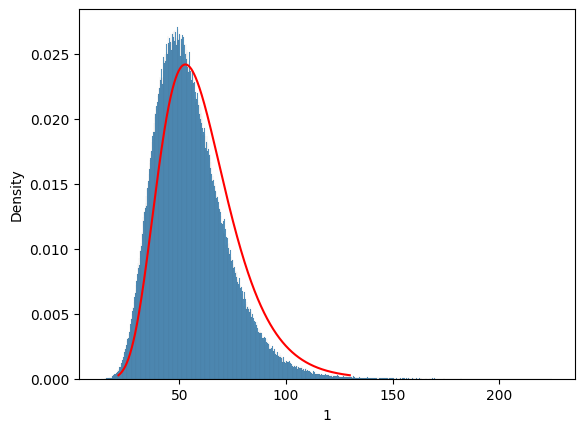

In [754]:
n = 2**19
r = 0.1
sigma = .3

data = milstein(s0=S, expiry_T=1, sigma=sigma, return_rate=r, n_periods=1, n_simulations=n).iloc[-1]

fx = [np.exp(-(x**2)/2)/np.sqrt(2*np.pi) for x in np.linspace(-3,3,n)]

x_lognorm = S*np.exp(r-(sigma*sigma)/2)*np.exp(np.linspace(-3,3,n)*sigma)
y_lognorm = fx
y_lognorm = y_lognorm/sum(np.diff(x_lognorm)*y_lognorm[1:])

fig, ax = plt.subplots()
sns.histplot(data,
             stat='density',
             bins=1000,
             ax=ax)

sns.lineplot(ax=ax,
             x=x_lognorm,
             y=y_lognorm,
             color='red')

2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

In [5]:
def delta_hedged_ptf(stock_path, K, T, sigma, r):

    df_hedged_ptf = pd.DataFrame(columns=['Cash_Position', 'Cash_Rebalance', 'Daily_Interest', '#_Stocks', 'Ptf_Stock', 'Ptf_Total'],
                                 index=range(0,len(stock_path)))
    
    
    s0 = stock_path[0]
    n_periods = len(stock_path)
    
    df_hedged_ptf['Cash_Position'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Cash_Rebalance'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Daily_Interest'] = [0.0]*len(df_hedged_ptf)

    df_hedged_ptf['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_hedged_ptf.index, stock_path)]
    df_hedged_ptf.loc[0, 'Cash_Position'] = -df_hedged_ptf.loc[0, '#_Stocks']*s0

    df_hedged_ptf['Ptf_Stock'] = df_hedged_ptf['#_Stocks']*stock_path
    df_hedged_ptf['Cash_Rebalance'] = -df_hedged_ptf['#_Stocks'].diff().fillna(0)*stock_path

    for i in df_hedged_ptf.index[1:]:

        df_hedged_ptf.loc[i, 'Daily_Interest'] = df_hedged_ptf.loc[i-1, 'Cash_Position']*r*T/n_periods
        df_hedged_ptf.loc[i, 'Cash_Position'] = df_hedged_ptf.loc[i-1, 'Cash_Position'] + df_hedged_ptf.loc[i, 'Cash_Rebalance'] + df_hedged_ptf.loc[i, 'Daily_Interest']

    df_hedged_ptf['Ptf_Total'] = df_hedged_ptf['Cash_Position'] + df_hedged_ptf['Ptf_Stock']

    return df_hedged_ptf


def call_ptf(stock_path, K, T,sigma, r):

    s0 = stock_path[0]
    n_periods = len(stock_path)

    V_i = black_scholes(S=s0, K=K, sigma=sigma, T=T, r=r)

    df_call_ptf = pd.DataFrame(columns=['Call_Price', 'Call_Carry', 'Call_PnL'],
                               index=range(0,len(stock_path)))

    df_call_ptf['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Carry'] = [V_i*(1-np.exp(r*T*t/n_periods)) for t in df_call_ptf.index]
    df_call_ptf['Call_PnL'] = df_call_ptf['Call_Price'] - df_call_ptf.loc[0,'Call_Price'] + df_call_ptf['Call_Carry']
    
    df_call_ptf['Call_Delta'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Gamma'] = [bs_gamma(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Theta'] = [bs_theta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    
    df_call_ptf['Call_Rho'] = [bs_rho(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Vega'] = [bs_vega(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]

    df_call_ptf['PnL_Delta'] = (df_call_ptf['Call_Delta'].shift(1)*stock_path.diff()).cumsum()
    df_call_ptf['PnL_Gamma'] = (df_call_ptf['Call_Gamma'].shift(1)*np.square(stock_path.diff())).cumsum()/2
    df_call_ptf['PnL_Theta'] = (df_call_ptf['Call_Theta'].shift(1)*T/n_periods).cumsum()
    df_call_ptf['PnL_Carry'] = df_call_ptf['Call_Carry']

    df_call_ptf['PnL_Greeks'] = df_call_ptf[['PnL_Delta','PnL_Gamma','PnL_Theta','PnL_Carry']].sum(axis=1)

    return df_call_ptf

    

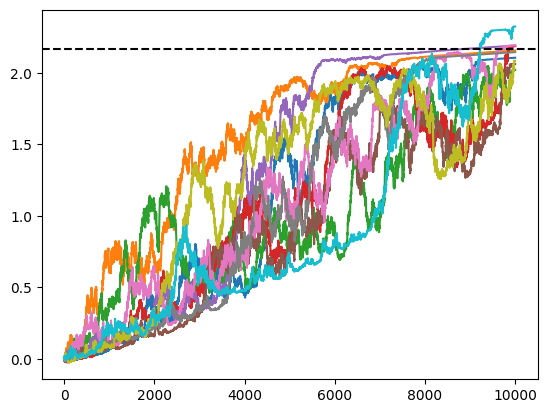

In [6]:
S = 50
K = 55
sigma_i = .30
sigma_a = .40

r = .1
T = 1.0 #in years

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


Hedging with actual volatiliy leads to a predicted PnL of V_a - V_i

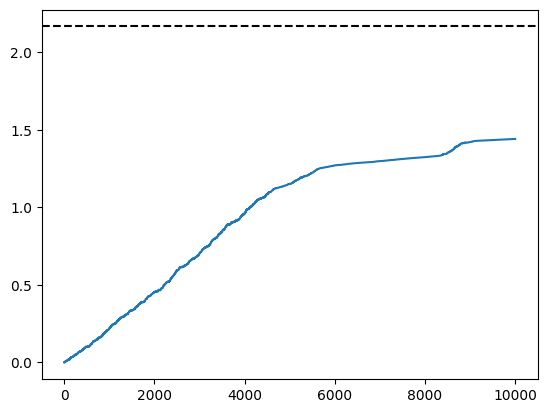

In [901]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

#df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns[0:1]:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


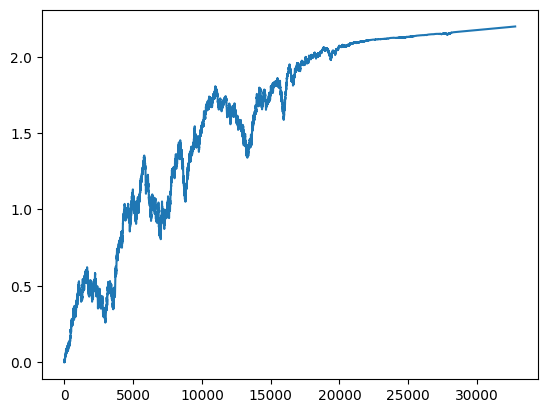

In [794]:
# n_periods = 2**15
# T = 1

# path_foo = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=1).iloc[:,0]
# path_foo = path_foo.to_frame(name='Stock_Price')

# #path_foo = path_foo.to_frame(name='Stock_Price')

# path_foo['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_i'] = [bs_delta(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_a'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]

# path_foo['Call_Carry'] = [-V_i*r*t*T/n_periods for t in path_foo.index]
# path_foo['Call_PnL'] = path_foo['Call_Price'] - path_foo.loc[0,'Call_Price'] + path_foo['Call_Carry']

# path_foo['Cash_Position'] = [0.0]*len(path_foo)
# path_foo['Cash_Rebalance'] = [0.0]*len(path_foo)
# path_foo['Daily_Interest'] = [0.0]*len(path_foo)

# path_foo['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo.loc[0, 'Cash_Position'] = -path_foo.loc[0, 'Call_Delta_a']*path_foo.loc[0, 'Stock_Price']

# path_foo['Ptf_Stock'] = path_foo['#_Stocks']*path_foo['Stock_Price']
# path_foo['Cash_Rebalance'] = -path_foo['#_Stocks'].diff().fillna(0)*path_foo['Stock_Price']

# for i in path_foo.index[1:]:

#     path_foo.loc[i, 'Daily_Interest'] = path_foo.loc[i-1, 'Cash_Position']*r*T/n_periods
#     path_foo.loc[i, 'Cash_Position'] = path_foo.loc[i-1, 'Cash_Position'] + path_foo.loc[i, 'Cash_Rebalance'] + path_foo.loc[i, 'Daily_Interest']

# path_foo['Ptf_Total'] = path_foo['Cash_Position'] + path_foo['Ptf_Stock']

# plt.plot(path_foo['Call_PnL'] - path_foo['Ptf_Total'])

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is\
the impact of time-dependent Gamma $ \Gamma_{t} $? <br> What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

#### $Total P\&L \approx \sum_{t}^{T} \frac{1}{2} \Gamma_{t} S^{2}_{t}\left [ r^2_{t} -\sigma_{t,imp}^2 \Delta t\right ] $

In [903]:
df_ptf.to_frame()

,Ptf_Total
0,-0.000000
1,-0.089632
2,-0.145654
3,-0.395525
4,-0.449857
...,...
9995,8.143731
9996,8.143813
9997,8.143894
9998,8.143975


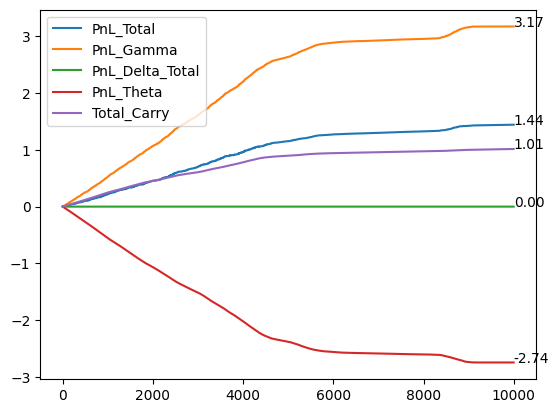

In [905]:
stock_path = df_price_paths.loc[:, i]

df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
df_ptf = -delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r)


df_total = df_call.merge(df_ptf, right_index=True, left_index=True)

df_total['PnL_Total'] = df_total[['Call_PnL', 'Ptf_Total']].sum(axis=1)
df_total['PnL_Delta_Total'] = df_total.PnL_Delta + df_total.Ptf_Stock.diff(1).cumsum() + df_total.Cash_Rebalance.cumsum()
df_total['Total_Carry'] = df_total['PnL_Carry'] + df_total['Daily_Interest'].cumsum()


df_total[['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']].plot()

for col in ['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']:
    
    plt.annotate('%.2f' % df_total[col].iloc[-1], xy=(n_periods, df_total[col].iloc[-1]))

plt.show()

<Axes: >

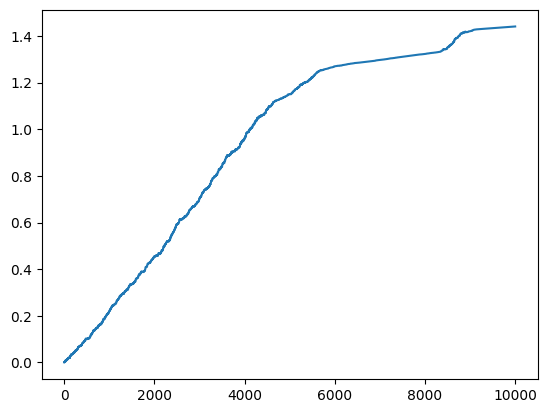

In [918]:
df_total[['PnL_Gamma', 'Total_Carry', 'PnL_Theta']].sum(1).plot()

<Axes: xlabel='period'>

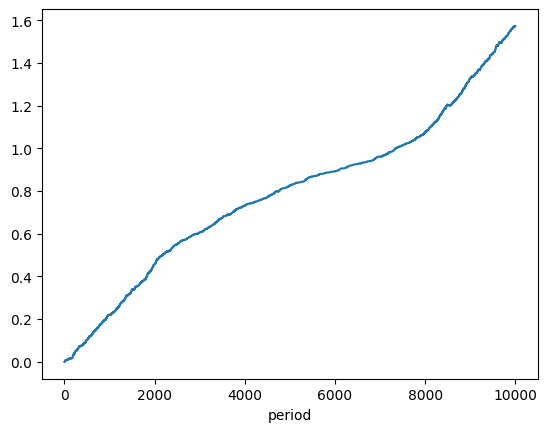

In [886]:
stock_path = df_price_paths.loc[:, 8]
gamma_array = np.array([bs_gamma(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(df_ptf.index, stock_path)])

(0.5*gamma_array*(stock_path**2)*(np.log(stock_path/stock_path.shift(1))**2-(sigma_i**2)/len(stock_path))).cumsum().plot()

In [866]:
np.sqrt(np.log(stock_path/stock_path.shift(1)).var()*10000)

0.3968411435730895

<Axes: >

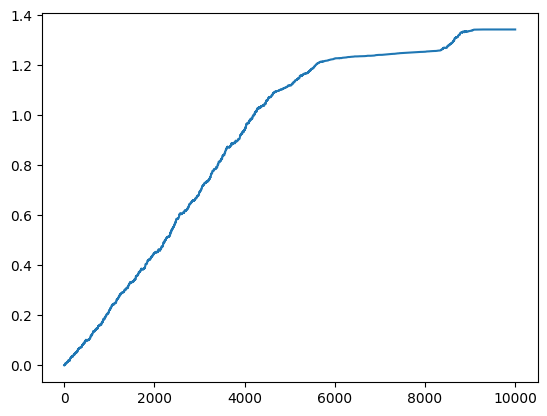

In [840]:
(0.5*df_call['Call_Gamma']*(stock_path**2)*(np.log(stock_path/stock_path.shift(1))**2-(sigma_i**2)/10000)).cumsum().plot()

In [824]:
(sigma_i**2)/n_periods

2.74658203125e-06

In [838]:
np.log(stock_path/stock_path.shift(1))**2

period
0            NaN
1       0.000010
2       0.000004
3       0.000075
4       0.000003
          ...   
9995    0.000025
9996    0.000013
9997    0.000023
9998    0.000006
9999    0.000004
Name: 0, Length: 10000, dtype: float64

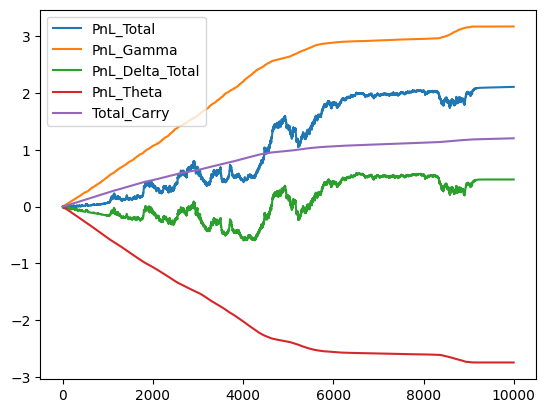

In [804]:
stock_path = df_price_paths.loc[:, 0]

df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
df_ptf = -delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r)

df_total = df_call.merge(df_ptf, right_index=True, left_index=True)

df_total['PnL_Total'] = df_total[['Call_PnL','Ptf_Total']].sum(axis=1)
df_total['PnL_Delta_Total'] = df_total.PnL_Delta + df_total.Ptf_Stock.diff(1).cumsum() + df_total.Cash_Rebalance.cumsum()
df_total['Total_Carry'] = df_total['PnL_Carry'] + df_total['Daily_Interest'].cumsum()


df_total[['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']].plot()

for col in ['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']:
    
    plt.annotate('%.2f' % df_total[col].iloc[-1], xy=(n_periods, df_total[col].iloc[-1]))

plt.show()

## Part II: Minimum Variance Delta

1. begin with sorting your IV data – or each trading day, you will need BS option price as
implied vol percentage, delta, and vega: ($ V_{t} $,$ \delta_{bs} $,$ \nu_{bs} $). <br> 
The term structure for option expiry $ 1M, 3M, 6M, 9M, 12M $, weekly expiries not necessary. <br> 
Key choice to make here, if
you are going to study Delta for out of the money call strikes, in addition to about ATM
buckets $ 0.45 < \delta_{bs} <0.55 $ – each strike means a separate a,b,c history for each expiry.

In [7]:
dict_dtpyes = {'[QUOTE_UNIXTIME]': int,
               ' [QUOTE_READTIME]' : object,
               ' [QUOTE_DATE]': str,
               ' [QUOTE_TIME_HOURS]': float, 
               ' [UNDERLYING_LAST]': float,
               ' [EXPIRE_DATE]': object,
               ' [EXPIRE_UNIX]': int,
               ' [DTE]': float,
               ' [C_DELTA]': object,
               ' [C_GAMMA]': object, 
               ' [C_VEGA]': object,
               ' [C_THETA]': object, 
               ' [C_RHO]': object, 
               ' [C_IV]': object, 
               ' [C_VOLUME]':object, 
               ' [C_LAST]': object,
               ' [C_SIZE]': object,
               ' [C_BID]': object, 
               ' [C_ASK]':object, 
               ' [STRIKE]': object, 
               ' [P_BID]':object,
               ' [P_ASK]':object,  
               ' [P_SIZE]':object, 
               ' [P_LAST]':object,
               ' [P_DELTA]': object,
               ' [P_GAMMA]': object,
               ' [P_VEGA]': object, 
               ' [P_THETA]': object, 
               ' [P_RHO]':object,
               ' [P_IV]':object,
               ' [P_VOLUME]': object,
               ' [STRIKE_DISTANCE]': float,
               ' [STRIKE_DISTANCE_PCT]': float}

csv_files = sorted(os.listdir('spx_eod_data'))

df_option_data = pd.DataFrame()

for file in csv_files:

    df_option_data = pd.concat([df_option_data,
                                pd.read_csv(filepath_or_buffer=f'spx_eod_data/{file}', 
                                            dtype=dict_dtpyes)
                                ])

# df_option_data = pd.read_csv(filepath_or_buffer='spx_eod_data/spx_eod_201001.txt')

#Parse Data
df_option_data.columns = [x.strip().replace('[','').replace(']','') for x in df_option_data.columns]
df_option_data['QUOTE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.QUOTE_DATE]
df_option_data['EXPIRE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.EXPIRE_DATE]

#df_option_data = df_option_data[[not((df_option_data.loc[x]==' ').any()) for x in df_option_data.index]]
df_option_data = df_option_data.replace(' ', np.nan)
df_option_data = df_option_data[~df_option_data.isna().any(axis=1)]
df_option_data = df_option_data.loc[df_option_data.DTE > 14]

for col in ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 'C_ASK',
            'STRIKE', 'P_BID', 'P_ASK', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 
            'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']:
    
    df_option_data[col] = [float(x) for x in df_option_data[col]]

df_option_data['C_MID'] = (df_option_data['C_ASK']+df_option_data['C_BID'])/2
df_option_data['P_MID'] = (df_option_data['P_ASK']+df_option_data['P_BID'])/2

df_option_data = df_option_data.reset_index(drop=True)

In [8]:
df_option_data['C_BS'] = [black_scholes(S=S,K=K,sigma=sigma,T=T/360,r=0) 
                          for S,K,sigma,T in zip(df_option_data['UNDERLYING_LAST'],
                                                 df_option_data['STRIKE'],
                                                 df_option_data['C_IV'], 
                                                 df_option_data['DTE'])]

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_97140/1444163933.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))


2. compute your dependent variable and run the fitting on $ \delta_{bs} $,$ \delta^2_{bs} $. <br>Dependent side based
on daily option price changes $ \Delta V_{t} $, and you will need $( \Delta S_{t} , S_{t}) $ as well as Greeks noted
above. <br> The exact data columns will depend on how you organise regression or do SLSQP.

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

holidays = cal.holidays(start=df_option_data.QUOTE_DATE.min(), 
                        end=df_option_data.QUOTE_DATE.max())

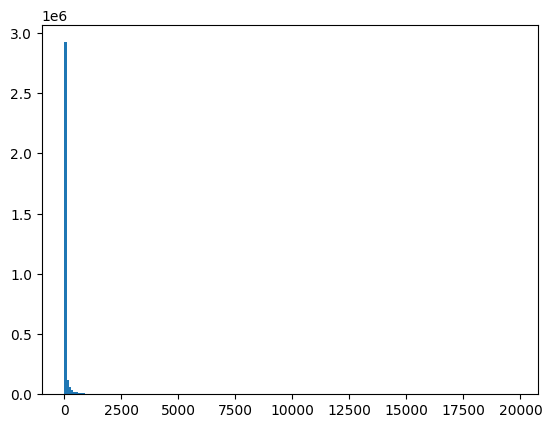

In [10]:
plt.hist(df_option_data.loc[:,'C_VOLUME'],bins=200)
plt.show()

In [ ]:
plt.boxplot(df_option_data.loc[:,'C_VOLUME'])

In [ ]:
pd.set_option('display.max_columns', None)

In [743]:
df_calls = df_option_data.set_index(['QUOTE_DATE','EXPIRE_UNIX','STRIKE'])[['UNDERLYING_LAST', 'DTE', 'C_DELTA', 'C_VEGA', 'C_IV', 'C_LAST','C_MID','C_BS','C_VOLUME']]
df_calls['QUOTE_DATE'] = df_calls.index.get_level_values(0)

df_calls = df_calls[(df_calls.C_DELTA < .95)&(df_calls.C_DELTA > .05)]
df_calls = df_calls[~df_calls.index.get_level_values(0).isin(holidays)].copy()


# Eliminate outliers prices compared to Black Scholes price

q75, q25 = np.percentile((df_calls['C_LAST']-df_calls['C_BS']).values,
                          [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls = df_calls[(df_calls['C_LAST']-df_calls['C_BS'] > cut_min) 
                    & (df_calls['C_LAST']-df_calls['C_BS'] < cut_max)].copy()

quote_dates = sorted(df_calls.index.get_level_values(0).unique())

df_calls_diff = df_calls.loc[quote_dates[0]].merge(
    df_calls.loc[quote_dates[1]], 
    left_index=True, 
    right_index=True, 
    suffixes=('_t1','_t0'), 
    how='inner')


for i in range(len(quote_dates[2:])):
    df_calls_diff = pd.concat([df_calls_diff,
                               df_calls.loc[quote_dates[i+1]].merge(
                                   df_calls.loc[quote_dates[i+2]], 
                                   left_index=True,
                                   right_index=True,
                                   suffixes=('_t1','_t0'),
                                   how='inner')],
                     axis=0)
    
df_calls_diff = df_calls_diff[df_calls_diff['C_LAST_t1']-df_calls_diff['C_LAST_t0'] != 0]
    
df_calls_diff['delta_price'] = df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1']
#df_calls_diff['delta_price'] = df_calls_diff['C_BS_t0'] - df_calls_diff['C_BS_t1']
df_calls_diff['delta_S'] = df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_price_perc'] = (df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1'])/df_calls_diff['C_LAST_t1']
df_calls_diff['delta_S_perc'] = (df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1'])/df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_IV'] = df_calls_diff['C_IV_t0']-df_calls_diff['C_IV_t1']

df_calls_diff['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_diff.C_DELTA_t1]
df_calls_diff['Expiry_Bucket'] = pd.cut(df_calls_diff.DTE_t1,[14, 30, 91, 182, 365, df_calls_diff.DTE_t1.max()],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

df_calls_diff = df_calls_diff[abs(df_calls_diff.delta_S_perc) > 1e-4].copy()
df_calls_diff = df_calls_diff.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket','Expiry_Bucket'])

df_calls_diff = df_calls_diff[df_calls_diff.C_VOLUME_t0!=0].copy()
df_calls_diff['delta_IV'] = df_calls_diff['C_IV_t0'] - df_calls_diff['C_IV_t1']

df_calls_diff['y'] = (df_calls_diff['delta_price']/df_calls_diff['delta_S']-df_calls_diff['C_DELTA_t1'])*df_calls_diff['UNDERLYING_LAST_t1']*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)
df_calls_diff['y_perc'] = (df_calls_diff['delta_price_perc']/df_calls_diff['delta_S_perc']-df_calls_diff['C_DELTA_t1'])*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)

df_calls_diff['delta_S_perc/sqrt_t'] = df_calls_diff['delta_S_perc']/np.sqrt(df_calls_diff['DTE_t0']/360)



In [744]:

# Eliminate outliers on y
q75, q25 = np.percentile(df_calls_diff.y, [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls_diff = df_calls_diff[(df_calls_diff['y'] > cut_min) & (df_calls_diff['y'] < cut_max)].copy()



{'whiskers': [<matplotlib.lines.Line2D at 0x304731370>,
 'caps': [<matplotlib.lines.Line2D at 0x32e1cf3e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x304732810>],
 'medians': [<matplotlib.lines.Line2D at 0x32e1cdaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x32e1cf380>],
 'means': []}

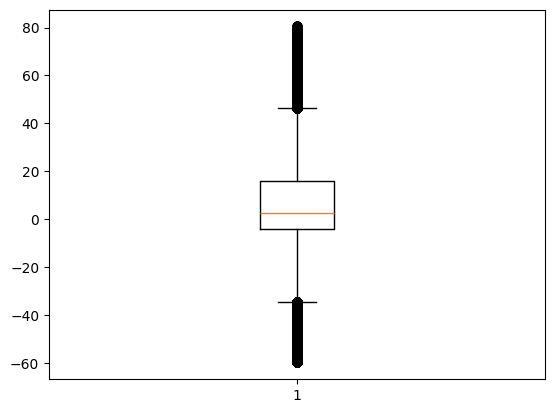

In [126]:
plt.boxplot(df_calls['C_BS']-df_calls['C_LAST'])

In [ ]:
plt.boxplot(df_calls_diff['y'])
plt.show()

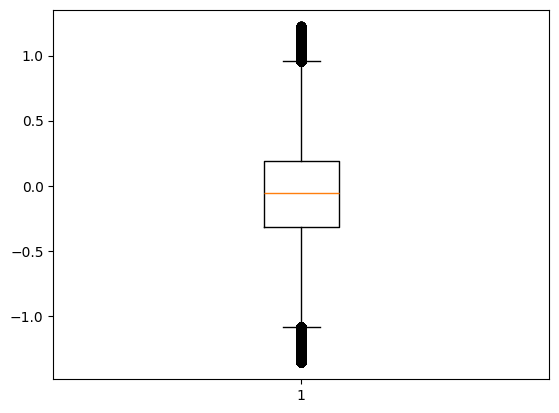

In [716]:
plt.boxplot(df_calls_diff['y'])
plt.show()

In [ ]:
# def quadratic_fit(df_option_prices):

#     df = df_option_prices.groupby(['Expiry_Bucket','BS_Delta_Bucket'],
#                                   observed=True).y.mean()

#     expiry_buckets  = df.index.get_level_values(0).unique()

#     df_result = pd.DataFrame(index=expiry_buckets,
#                              columns=['a', 'b', 'c'])

#     for expiry in expiry_buckets:

#         c,b,a = np.polyfit(y=df.loc[expiry],
#                            x=df.loc[expiry].index,
#            deg=2)
        
#         df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]

#     return df_result


# for i in range(0, len(df_quote_dates)-21*36):

#     training_period = df_quote_dates.loc[i:i+21*36].values
#     testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

#     df_params.loc[training_period[-1], ['a', 'b', 'c']] = quadratic_fit(df_calls_diff.loc[training_period]).values

#     print(training_period[-1])

#df_params['minus_b'] = -df_params['b']

In [717]:
TRAINING_PERIOD = 21*36 #36 months
TESTING_PERIOD= 60 #1 month

In [718]:
df_quote_dates = pd.Series(df_calls_diff.index.get_level_values(0).unique())

# i = len(df_quote_dates)-TRAINING_PERIOD
# testing_period = df_quote_dates.loc[i:i+TRAINING_PERIOD].values


import itertools

lists = [
   df_quote_dates.loc[TRAINING_PERIOD:].values,
   df_calls_diff.index.get_level_values(2).unique().categories.to_list() + ['Total']
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[TRAINING_PERIOD:].values, df_quote_dates.loc[:].values)})



In [242]:
i=0

training_period = df_quote_dates.loc[i:i+21*36].values
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values


print(quadratic_fit_perc(df_calls_diff.loc[training_period]).values)

[[0.20310617644249251 -0.5172128498006097 0.39891975088276954]
 [nan nan nan]
 [nan nan nan]
 [0.039825690280910306 -0.09981709243961286 0.07863220025784143]
 [0.02474085875875948 -0.06376067632463907 0.05326775298688068]
 [nan nan nan]]


In [745]:
df_quote_dates = pd.Series(df_calls_diff.index.get_level_values(0).unique())

import itertools

lists = [
   df_quote_dates.loc[TRAINING_PERIOD:].values,
   df_calls_diff.index.get_level_values(2).unique().categories.to_list() + ['Total']
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[TRAINING_PERIOD:].values, df_quote_dates.loc[:].values)})


def get_r_squared(df_option_prices):

    df = df_option_prices[['delta_IV', 'delta_S_perc', 'DTE_t1']].copy()
    df['x'] = df['delta_S_perc']/np.sqrt(df['DTE_t1']/360)
    result = pd.Series(index=sorted(df.index.get_level_values(1).unique()))

    for bs_bucket in sorted(df.index.get_level_values(1).unique()):

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y=df.xs(bs_bucket, level='BS_Delta_Bucket').delta_IV,
                                                                        x=df.xs(bs_bucket, level='BS_Delta_Bucket').x)
        
        result.loc[bs_bucket] = r_value**2
        
    return result
    
    
def quadratic_fit(df_option_prices):

    df = df_option_prices.groupby(['Expiry_Bucket','BS_Delta_Bucket'],
                                  observed=True).y.mean()

    expiry_buckets  = df.index.get_level_values(0).unique().to_list() + ['Total']

    df_result = pd.DataFrame(index=expiry_buckets,
                             columns=['a', 'b', 'c'])

    for expiry in expiry_buckets[:-1]:

        c,b,a = np.polyfit(y=df.loc[expiry],
                           x=df.loc[expiry].index,
           deg=2)
        
        df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]
    
    c,b,a = np.polyfit(y=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                  observed=True).y.mean(),
                        x=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                  observed=True).y.mean().index,
        deg=2)
    
    df_result.loc['Total',['a', 'b', 'c']] = [a, b, c]

    return df_result

for i in range(0, len(df_quote_dates)-TRAINING_PERIOD):

    training_period = df_quote_dates.loc[i:i+TRAINING_PERIOD].values

    df_params.loc[training_period[-1], ['a', 'b', 'c']] = quadratic_fit(df_calls_diff.loc[training_period]).values
    #df_r_squared.loc[training_period[-1]] = get_r_squared(df_calls_diff.loc[training_period])

df_params['minus_b'] = -df_params['b']

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_97140/2713361060.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


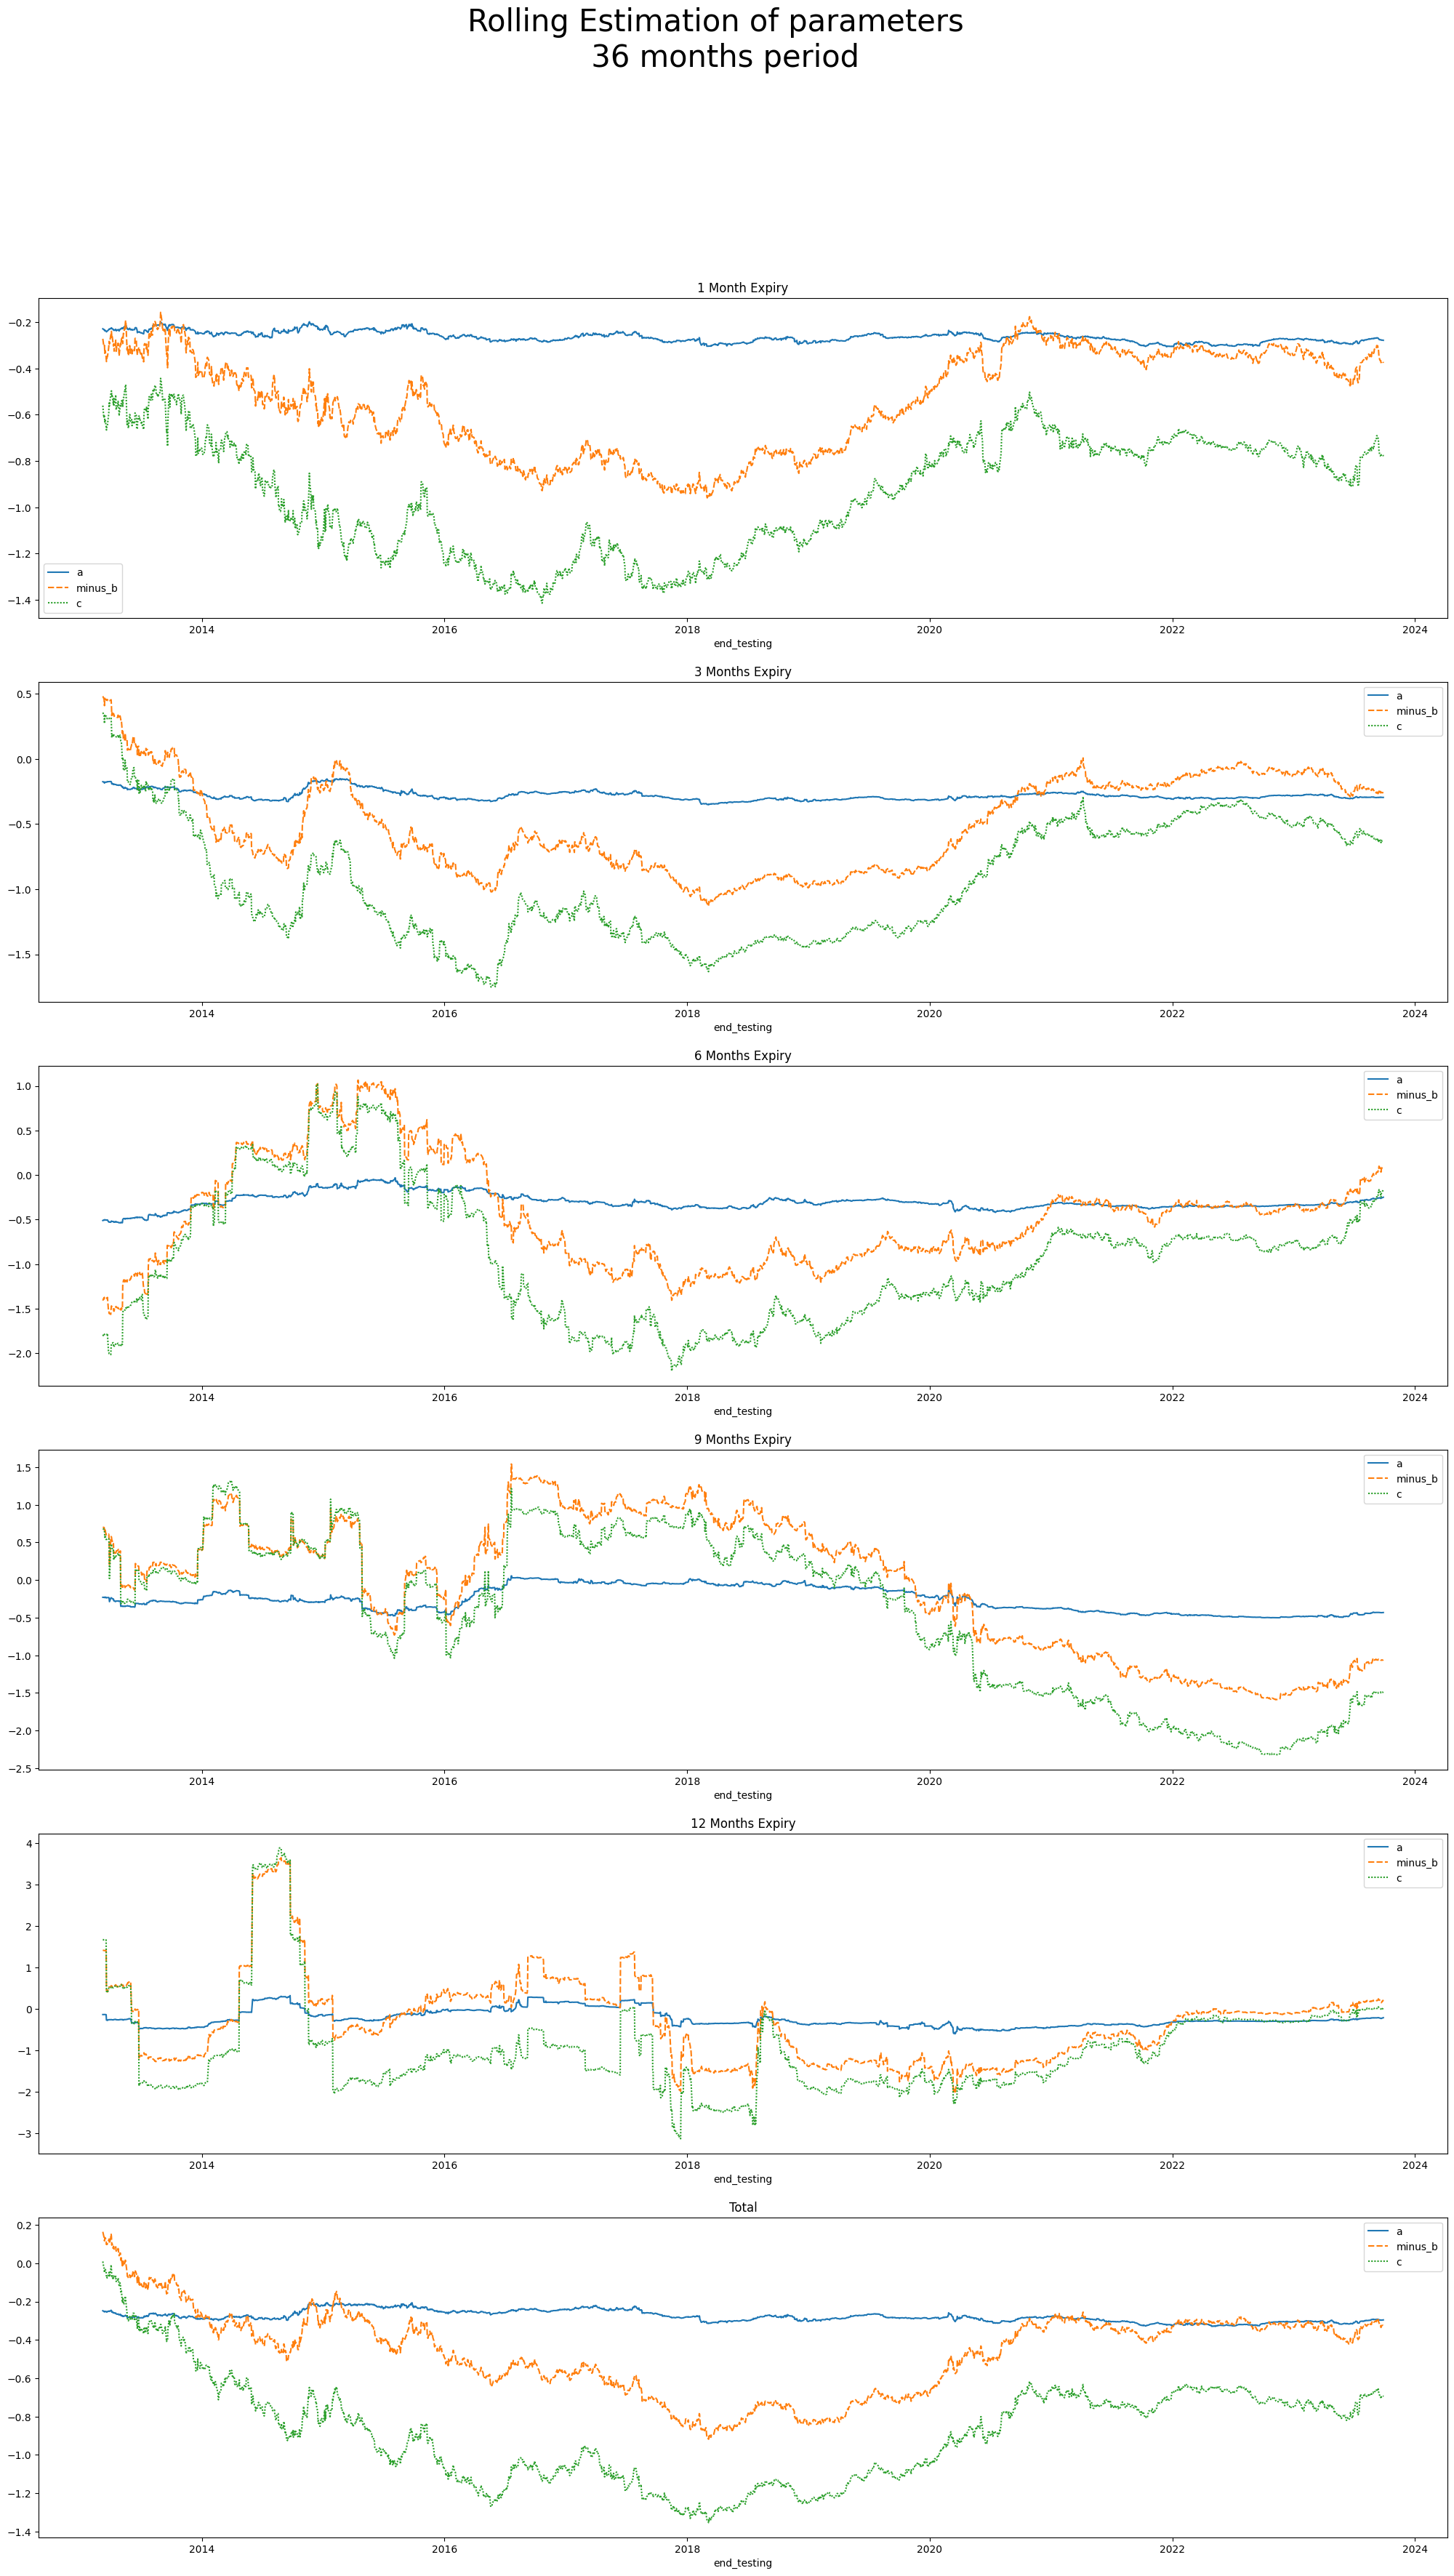

In [746]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(25,40))

fig.suptitle('Rolling Estimation of parameters \n 36 months period', 
             fontsize=30)


sns.lineplot(df_params.xs('1M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[0])
ax[0].set_title('1 Month Expiry')

sns.lineplot(df_params.xs('3M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[1])
ax[1].set_title('3 Months Expiry')

sns.lineplot(df_params.xs('6M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[2])
ax[2].set_title('6 Months Expiry')

sns.lineplot(df_params.xs('9M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[3])
ax[3].set_title('9 Months Expiry')

sns.lineplot(df_params.xs('12M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[4])
ax[4].set_title('12 Months Expiry')

sns.lineplot(df_params.xs('Total',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[5])
ax[5].set_title('Total')

fig.show()


In [ ]:
import timeit

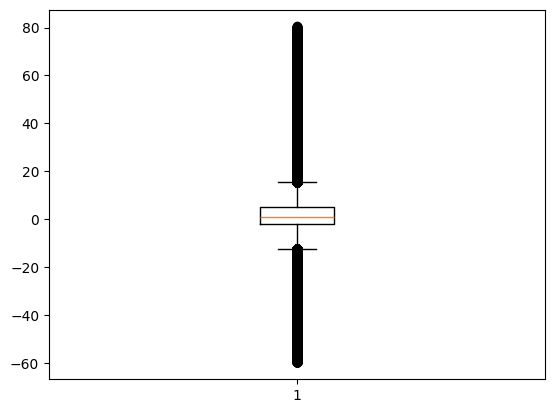

In [571]:
plt.boxplot(df_calls_diff['C_BS_t0']-df_calls_diff['C_LAST_t0'])
plt.show()

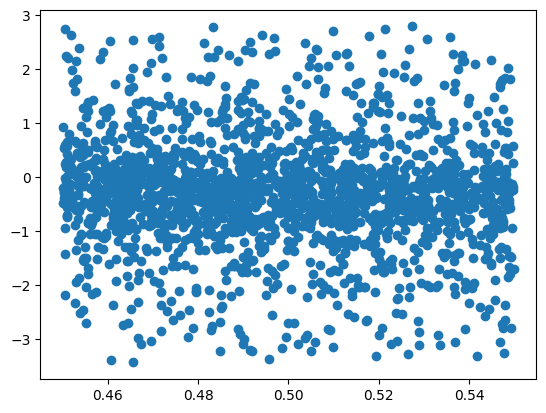

In [747]:
#i=len(df_quote_dates)-21*36
i=0
training_period = df_quote_dates.loc[i:i+21*36].values

plt.scatter(x=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').C_DELTA_t1.to_numpy(),
            y=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').y.to_numpy())

In [ ]:
df_comp_data = pd.read_csv('2013-01-16options.csv')

df_comp_data = df_comp_data.loc[(df_comp_data.underlying == 'SPX') & (df_comp_data.volume > 0) & (df_comp_data.expiration > '2013-03-01')]
df_comp_data = df_comp_data[df_comp_data.strike == 1450]
df_comp_data = df_comp_data[df_comp_data.type == 'call']

df_comp_data.sort_values('expiration')

In [ ]:
df_option_data[(df_option_data['QUOTE_DATE'] == '2013-01-16')&(df_option_data['STRIKE'] == 1450)]

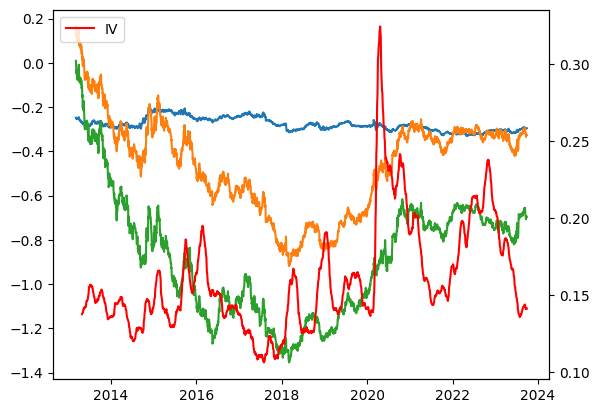

In [748]:
expiry_bucket = 'Total'

fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df_params.xs(expiry_bucket,level=1).index,
         df_params.xs(expiry_bucket,level=1)[['a','b','c']]*[1,-1,1]
         )


ax2.plot(df_calls_diff.xs('6M', level='Expiry_Bucket').loc[df_params.index.get_level_values(0).min():].groupby('QUOTE_DATE_t1').C_IV_t0.mean().rolling(30).mean(),
         label='IV',
         color='r')

plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

### Assesing Gains

In [ ]:
# def sse_bs(df_option_prices, expiry_bucket, delta_bucket):

#     df = (df_option_prices
#           .xs(delta_bucket,level='BS_Delta_Bucket')
#           .xs(expiry_bucket, level='Expiry_Bucket'))
    
#     epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S

#     return sum(epsilon_bs**2)


# def sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

#     df = (df_option_prices
#           .xs(delta_bucket,level='BS_Delta_Bucket')
#           .xs(expiry_bucket, level='Expiry_Bucket'))
    
#     a,b,c = df_params.loc[expiry_bucket,['a','b','c']]
    
#     epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S
#     epsilon_mv = epsilon_bs - (((df.C_VEGA_t1*100)*df.delta_S)/(np.sqrt(df.DTE_t1/360)*df.UNDERLYING_LAST_t1))*(a+b*df.C_DELTA_t1 + c*(df.C_DELTA_t1**2))


#     return sum(epsilon_mv**2)


# def gain_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

#     _sse_bs = sse_bs(df_option_prices, expiry_bucket, delta_bucket)
#     _sse_mv = sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket)

#     return 1-_sse_mv/_sse_bs

In [723]:
TESTING_PERIOD = 60

In [749]:
#declare df_gain_n_observations
lists = [
   df_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique())
   ]

df_gain_n_observations = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                                      columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_n_observations.index.names = ['start_testing','delta_bucket']

#declare df_r_squared
lists = [
   df_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']
   ]

df_r_squared = pd.DataFrame(index=df_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
                            columns=sorted(df_calls_diff.index.get_level_values(1).unique()))

lists = [
   df_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']
   ]

#df_gain_mv
df_gain_mv = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                          columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_mv.index.names = ['start_testing','delta_bucket']
df_gain_mv['Total'] = np.nan



for i in range(0, len(df_quote_dates)-TRAINING_PERIOD-TESTING_PERIOD-1):
    
        testing_period = df_quote_dates.loc[i+TRAINING_PERIOD: i+TRAINING_PERIOD+TESTING_PERIOD].values

        df_loop = pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                           df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                           left_on = 'Expiry_Bucket',
                           right_on = 'expiry_bucket'
                           )

        df_loop['epsilon_bs'] = df_loop['delta_price'] - df_loop['BS_Delta_Bucket']*df_loop['delta_S']

        df_loop['Delta_MV'] = df_loop['BS_Delta_Bucket'] + (df_loop['C_VEGA_t1']*100
                                                            *(df_loop['a']+df_loop['b']*df_loop['BS_Delta_Bucket']+df_loop['c']*(df_loop['BS_Delta_Bucket']**2))
                                                            /(np.sqrt(df_loop['DTE_t1']/360)*df_loop['UNDERLYING_LAST_t1']))

        df_loop['epsilon_mv'] = df_loop['delta_price'] - df_loop['Delta_MV']*df_loop['delta_S']

        df_epsilon_bs = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_bs)**2))
                                        .unstack())

        df_epsilon_bs['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_bs)**2)))


        df_epsilon_bs.loc['Total'] = (df_loop
                                      .groupby('Expiry_Bucket',
                                               observed=True)
                                               .apply(lambda x: sum((x.epsilon_bs)**2)))

        df_epsilon_bs.loc['Total', 'Total'] = sum(df_loop['epsilon_bs']**2)

        df_epsilon_mv = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_mv)**2))
                                        .unstack())

        df_epsilon_mv['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))


        df_epsilon_mv.loc['Total'] = (df_loop
                                        .groupby('Expiry_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))

        df_epsilon_mv.loc['Total', 'Total'] = sum(df_loop['epsilon_mv']**2)

        if len(df_epsilon_mv.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

                for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_mv.columns):

                        df_epsilon_mv[col] = np.nan

        if len(df_epsilon_bs.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

                for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_bs.columns):

                        df_epsilon_bs[col] = np.nan

        df_epsilon_bs = df_epsilon_bs[df_gain_mv.loc[testing_period[1]].columns]
        df_epsilon_mv = df_epsilon_mv[df_gain_mv.loc[testing_period[1]].columns]

        df_gain_mv.loc[testing_period[1]].loc[df_epsilon_mv.index] = (1 - df_epsilon_mv/df_epsilon_bs)

        
        df_loop_observations = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'], observed=True)
                                .QUOTE_DATE_t1.count()
                                .unstack()[df_gain_n_observations.loc[testing_period[1]].columns]
                                .values)
        
        df_gain_n_observations.loc[testing_period[1]] = df_loop_observations
        df_r_squared.loc[testing_period[1]] = get_r_squared(df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket']))
        
        # #remove data with less than 10 comparisons in the period
        # df_n_observations = df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'], observed=True).QUOTE_DATE_t1.count().unstack()
        # df_n_observations['Total'] = df_n_observations.sum(axis=1)

        # df_n_observations = df_n_observations[df_gain_mv.loc[testing_period[1]].columns]
        # df_gain_mv.loc[testing_period[0]][df_n_observations < 10] = np.nan

df_gain_mv = df_gain_mv.astype(float)
df_r_squared = df_r_squared.astype(float)

df_gain_n_observations['Total'] = df_gain_n_observations.sum(1)

2013-03-11T00:00:00.000000000
2013-03-12T00:00:00.000000000
2013-03-13T00:00:00.000000000
2013-03-14T00:00:00.000000000
2013-03-15T00:00:00.000000000
2013-03-18T00:00:00.000000000
2013-03-19T00:00:00.000000000
2013-03-20T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-22T00:00:00.000000000
2013-03-25T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-27T00:00:00.000000000
2013-03-28T00:00:00.000000000
2013-04-01T00:00:00.000000000
2013-04-02T00:00:00.000000000
2013-04-03T00:00:00.000000000
2013-04-04T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-08T00:00:00.000000000
2013-04-09T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-11T00:00:00.000000000
2013-04-12T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-16T00:00:00.000000000
2013-04-17T00:00:00.000000000
2013-04-18T00:00:00.000000000
2013-04-19T00:00:00.000000000
2013-04-22T00:00:00.000000000
2013-04-23T00:00:00.000000000
2013-04-24T00:00:00.000000000
2013-04-25T00:00:00.000000000
2013-04-26

In [751]:
df_gain_mv.groupby('delta_bucket').mean()

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,-0.091337,-0.117227,-0.129143,-0.267824,-0.363642,-0.038069
0.2,0.090579,0.122563,-1.586282,-0.144384,-1.594128,0.107267
0.3,0.127377,0.110674,0.019210,0.086237,-0.199807,0.115426
0.4,0.147798,0.141777,0.109044,-0.018915,0.110950,0.132007
0.5,0.182326,0.182788,0.186453,0.133011,0.113966,0.173024
0.6,0.176213,0.164060,0.177229,0.154146,0.117386,0.169673
0.7,0.182157,0.194419,0.111494,0.175098,0.215582,0.188407
0.8,0.186529,0.238479,0.163559,0.148929,-1.467170,0.210311
0.9,0.191868,0.202765,-2.166240,-0.289737,-1.918757,0.217022


In [737]:
(df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'], observed=True)
                        .QUOTE_DATE_t1.count().unstack())

Expiry_Bucket,1M,3M,6M,9M
BS_Delta_Bucket,,,,
0.1,24.0,1.0,NaN,NaN
0.2,441.0,82.0,NaN,NaN
0.3,1114.0,768.0,35.0,NaN
0.4,1426.0,1353.0,485.0,121.0
0.5,1615.0,1785.0,786.0,272.0
0.6,1453.0,1667.0,830.0,138.0
0.7,1067.0,1138.0,570.0,52.0
0.8,762.0,767.0,279.0,28.0
0.9,396.0,305.0,83.0,13.0


In [739]:
df_loop_observations

Expiry_Bucket,1M,3M,6M,9M
BS_Delta_Bucket,,,,
0.1,24.0,1.0,NaN,NaN
0.2,441.0,82.0,NaN,NaN
0.3,1114.0,768.0,35.0,NaN
0.4,1426.0,1353.0,485.0,121.0
0.5,1615.0,1785.0,786.0,272.0
0.6,1453.0,1667.0,830.0,138.0
0.7,1067.0,1138.0,570.0,52.0
0.8,762.0,767.0,279.0,28.0
0.9,396.0,305.0,83.0,13.0


In [726]:
df_gain_mv

1M        3M        6M        9M  \
start_testing delta_bucket                                           
2013-04-19    0.1          -0.321207 -0.069448 -0.396938 -0.041752   
              0.2          -0.274242 -0.477723 -0.248018  0.016205   
              0.3           0.187159 -0.073013  0.352978 -0.113767   
              0.4           0.066093 -0.097283 -0.119225  -0.20058   
              0.5           0.039136 -0.047517  -0.32013  0.036991   
...                              ...       ...       ...       ...   
2023-06-23    0.6                NaN       NaN       NaN       NaN   
              0.7                NaN       NaN       NaN       NaN   
              0.8                NaN       NaN       NaN       NaN   
              0.9                NaN       NaN       NaN       NaN   
              Total              NaN       NaN       NaN       NaN   

                                   12M     Total  
start_testing delta_bucket                        
2013-04-19    0.1             -0.34688 -0.319748  
              0.2          -383.605695 -0.204515  
              0.3                  NaN  0.114629  
              0.4            -0.188292 -0.011366  
              0.5            -0.207575 -0.040429  
...                                ...       ...  
2023-06-23    0.6                  NaN       NaN  
              0.7                  NaN       NaN  
              0.8                  NaN       NaN  
              0.9                  NaN       NaN  
              Total                NaN       NaN  

[24310 rows x 6 columns]

In [727]:
df_gain_mv.groupby('delta_bucket').mean()

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,-0.141329,-3.158051,-0.065452,-0.08099,0.061401,-0.102846
0.2,0.001686,0.017081,-0.000054,0.000198,-4.86622,0.003709
0.3,0.033253,0.003911,0.003507,-1.009587,-0.001987,0.017343
0.4,0.030062,0.004071,-0.0013,-0.002122,-0.076804,0.013581
0.5,0.037574,0.013324,-0.00069,0.006882,-0.037117,0.016864
0.6,0.049149,0.026461,0.027681,0.022942,-0.042732,0.034773
0.7,0.05211,0.046215,0.011613,-0.084402,-1.077853,0.049179
0.8,0.047458,0.07522,0.083771,-0.091132,-0.637179,0.066456
0.9,0.045683,0.08741,-0.78397,0.088068,-0.25687,0.074483


<Axes: >

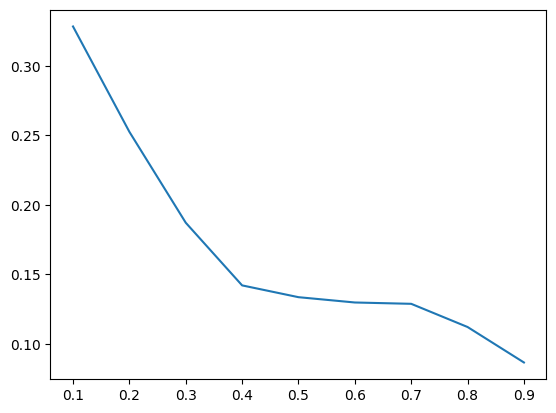

In [728]:
df_r_squared.mean().plot()

In [687]:
df_r_squared.loc[testing_period[1]] = get_r_squared(df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket']))

<Axes: xlabel='delta_bucket'>

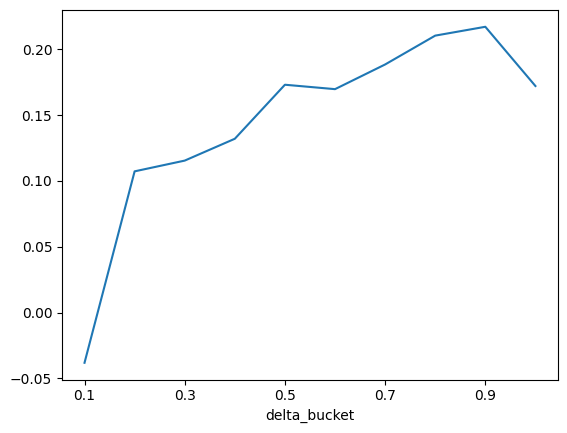

In [752]:
df_gain_mv.groupby('delta_bucket').mean().Total.plot()

In [753]:
df_r_squared

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
QUOTE_DATE_t1,,,,,,,,,
2013-03-11,0.308370,0.681389,0.273025,0.182842,0.057521,0.077537,0.048129,0.035903,0.003690
2013-03-12,0.308480,0.677968,0.276488,0.190730,0.060020,0.080498,0.049801,0.035560,0.003762
2013-03-13,0.307152,0.650151,0.246643,0.165119,0.039695,0.070043,0.038540,0.034883,0.000073
2013-03-14,0.307415,0.650151,0.243492,0.165203,0.038301,0.068804,0.038419,0.038356,0.000008
2013-03-15,0.307415,0.650268,0.251362,0.173685,0.045888,0.071870,0.039038,0.042190,0.000007
...,...,...,...,...,...,...,...,...,...
2023-06-23,0.151797,0.009515,0.005449,0.000028,0.006944,0.021426,0.027075,0.022058,0.097668
2023-06-26,0.127803,0.008331,0.005229,0.000021,0.005296,0.018862,0.025772,0.020589,0.095451
2023-06-27,0.127803,0.001159,0.006301,0.023694,0.001637,0.002255,0.008711,0.010631,0.079724


In [742]:
get_r_squared(df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket']))

0.1    0.060294
0.2    0.025794
0.3    0.048932
0.4    0.058200
0.5    0.083800
0.6    0.103749
0.7    0.088149
0.8    0.104168
0.9    0.130923
dtype: float64

In [613]:
df_gain_n_observations = df_gain_n_observations.fillna(0)

In [676]:
df_gain_n_observations

1M      3M     6M     9M   12M   Total
start_testing delta_bucket                                            
2013-03-11    0.1             25.0     4.0    3.0    6.0  23.0    61.0
              0.2             20.0     6.0    3.0   15.0   1.0    45.0
              0.3             49.0    29.0   11.0   16.0   0.0   105.0
              0.4            104.0    88.0   11.0   28.0   7.0   238.0
              0.5            137.0   157.0   46.0   40.0  60.0   440.0
...                            ...     ...    ...    ...   ...     ...
2023-06-29    0.5           1422.0  1554.0  695.0  163.0   0.0  3834.0
              0.6           1156.0  1338.0  663.0   83.0   0.0  3240.0
              0.7            804.0   831.0  338.0   15.0   1.0  1989.0
              0.8            471.0   431.0  140.0    6.0   0.0  1048.0
              0.9            162.0   154.0   42.0    2.0   0.0   360.0

[22644 rows x 6 columns]

In [653]:
df_gain_n_observations['Total'] = df_gain_n_observations.sum(1)

In [654]:
df_gain_n_observations

1M      3M     6M     9M   12M   Total
start_testing delta_bucket                                            
2013-03-11    0.1             25.0     4.0    3.0    6.0  23.0    61.0
              0.2             20.0     6.0    3.0   15.0   1.0    45.0
              0.3             49.0    29.0   11.0   16.0   0.0   105.0
              0.4            104.0    88.0   11.0   28.0   7.0   238.0
              0.5            137.0   157.0   46.0   40.0  60.0   440.0
...                            ...     ...    ...    ...   ...     ...
2023-06-29    0.5           1422.0  1554.0  695.0  163.0   0.0  3834.0
              0.6           1156.0  1338.0  663.0   83.0   0.0  3240.0
              0.7            804.0   831.0  338.0   15.0   1.0  1989.0
              0.8            471.0   431.0  140.0    6.0   0.0  1048.0
              0.9            162.0   154.0   42.0    2.0   0.0   360.0

[22644 rows x 6 columns]

In [740]:
df_gain_n_observations['Total'].groupby(['start_testing','delta_bucket']).mean().unstack().plot()

KeyError: 'Total'

In [674]:
df_gain_n_observations

1M      3M     6M     9M   12M   Total
start_testing delta_bucket                                            
2013-03-11    0.1             25.0     4.0    3.0    6.0  23.0    61.0
              0.2             20.0     6.0    3.0   15.0   1.0    45.0
              0.3             49.0    29.0   11.0   16.0   0.0   105.0
              0.4            104.0    88.0   11.0   28.0   7.0   238.0
              0.5            137.0   157.0   46.0   40.0  60.0   440.0
...                            ...     ...    ...    ...   ...     ...
2023-06-29    0.5           1422.0  1554.0  695.0  163.0   0.0  3834.0
              0.6           1156.0  1338.0  663.0   83.0   0.0  3240.0
              0.7            804.0   831.0  338.0   15.0   1.0  1989.0
              0.8            471.0   431.0  140.0    6.0   0.0  1048.0
              0.9            162.0   154.0   42.0    2.0   0.0   360.0

[22644 rows x 6 columns]

<Axes: xlabel='start_testing'>

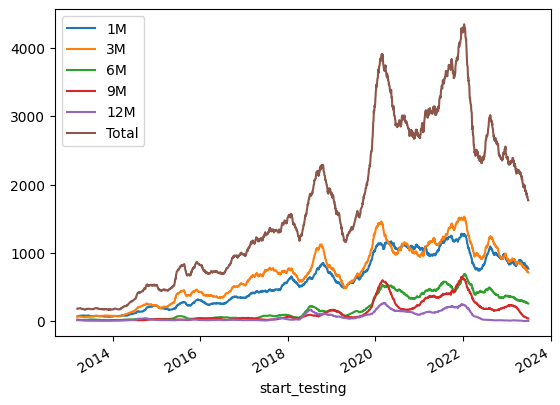

In [673]:
df_gain_n_observations.groupby('start_testing').mean().plot()

<Axes: xlabel='start_testing'>

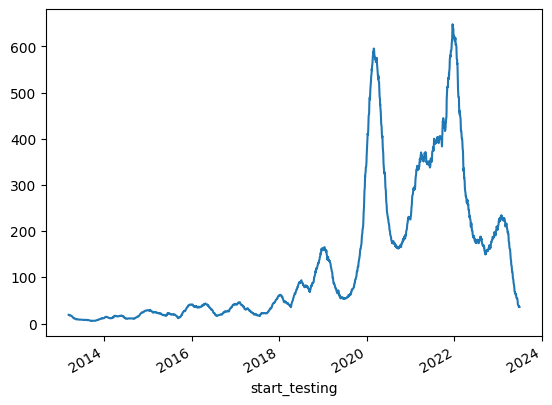

In [635]:
df_gain_n_observations.groupby('start_testing').mean()['9M'].plot()

<Axes: xlabel='start_testing'>

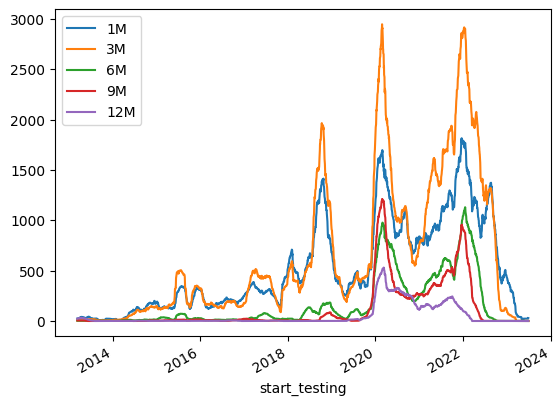

In [640]:
df_gain_n_observations.xs(.1,level='delta_bucket').plot()

<Axes: xlabel='start_testing'>

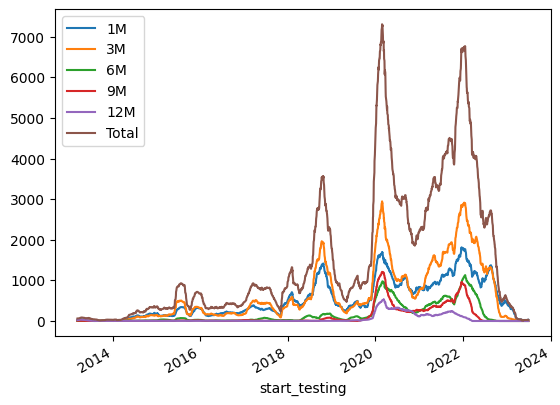

In [669]:
df_gain_n_observations.xs(.1,level='delta_bucket').plot()

In [675]:
df_gain_mv.groupby('delta_bucket').mean()

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,-0.091337,-0.117227,-0.129143,-0.267824,-0.363642,-0.038069
0.2,0.090579,0.122563,-1.586282,-0.144384,-1.594128,0.107267
0.3,0.127377,0.110674,0.019210,0.086237,-0.199807,0.115426
0.4,0.147798,0.141777,0.109044,-0.018915,0.110950,0.132007
0.5,0.182326,0.182788,0.186453,0.133011,0.113966,0.173024
0.6,0.176213,0.164060,0.177229,0.154146,0.117386,0.169673
0.7,0.182157,0.194419,0.111494,0.175098,0.215582,0.188407
0.8,0.186529,0.238479,0.163559,0.148929,-1.467170,0.210311
0.9,0.191868,0.202765,-2.166240,-0.289737,-1.918757,0.217022


<Axes: xlabel='start_testing'>

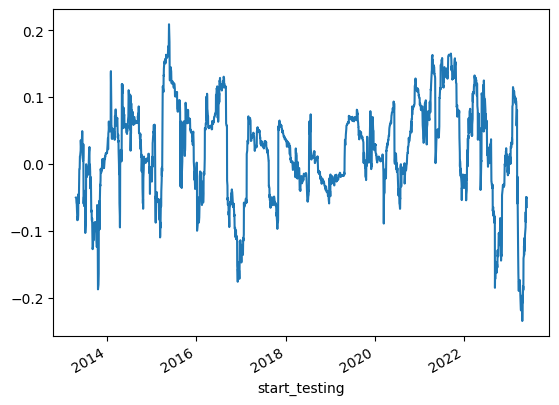

In [733]:
df_gain_mv.groupby('start_testing').mean().Total.plot()

In [638]:
df_calls_diff.loc[training_period]

UNDERLYING_LAST_t1  DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2010-01-04    0.7             3M                        1132.99   45.00   
                              3M                        1132.99   45.00   
                              3M                        1132.99   45.00   
                              3M                        1132.99   45.00   
              0.6             3M                        1132.99   45.00   
...                                                         ...     ...   
2013-03-08    0.6             6M                        1550.77  111.96   
              0.5             9M                        1550.77  286.00   
              0.4             9M                        1550.77  286.00   
                              12M                       1550.77  650.00   
                              12M                       1550.77  650.00   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2010-01-04    0.7             3M                0.74893    1.27133  0.20731   
                              3M                0.73001    1.31920  0.20442   
                              3M                0.70983    1.36823  0.20162   
                              3M                0.68832    1.41197  0.19919   
              0.6             3M                0.64325    1.49082  0.19229   
...                                                 ...        ...      ...   
2013-03-08    0.6             6M                0.58090    3.33922  0.13749   
              0.5             9M                0.48980    5.38478  0.14734   
              0.4             9M                0.37909    5.16455  0.13771   
                              12M               0.43048    7.88732  0.16286   
                              12M               0.39741    7.76203  0.15871   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                 63.67    63.400   65.509333   
                              3M                 59.50    59.405   61.526854   
                              3M                 55.15    55.605   57.636464   
                              3M                 50.70    51.795   53.883990   
              0.6             3M                 44.60    44.500   46.368799   
...                                                ...       ...         ...   
2013-03-08    0.6             6M                 55.00    56.395   61.033566   
              0.5             9M                 68.00    70.745   81.554554   
              0.4             9M                 45.15    46.100   54.961301   
                              12M                91.00    92.200  114.038756   
                              12M                81.00    80.955  100.939182   

                                             C_VOLUME_t1  UNDERLYING_LAST_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                    10.0             1136.40   
                              3M                    14.0             1136.40   
                              3M                    19.0             1136.40   
                              3M                    13.0             1136.40   
              0.6             3M                    26.0             1136.40   
...                                                  ...                 ...   
2013-03-08    0.6             6M                     2.0             1556.12   
              0.5             9M                   756.0             1556.12   
              0.4             9M                    26.0             1556.12   
                              12M                  262.0             1556.12   
                              12M       

In [576]:
df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket'])

UNDERLYING_LAST_t1   DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                
2023-06-29    0.8             1M                        4397.04    18.00   
                              1M                        4397.04    18.00   
                              1M                        4397.04    18.00   
              0.7             1M                        4397.04    18.00   
                              1M                        4397.04    18.00   
...                                                         ...      ...   
2023-09-27    0.6             9M                        4274.72   233.00   
              0.5             9M                        4274.72   233.00   
                              9M                        4274.72   268.00   
                              9M                        4274.72   275.00   
2023-07-10    0.7             12M                       4410.22  1257.04   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2023-06-29    0.8             1M                0.83190    2.50912  0.11310   
                              1M                0.77907    2.95860  0.10806   
                              1M                0.75452    3.13858  0.10676   
              0.7             1M                0.74121    3.22784  0.10558   
                              1M                0.72621    3.31699  0.10420   
...                                                 ...        ...      ...   
2023-09-27    0.6             9M                0.57910   13.31399  0.16735   
              0.5             9M                0.47237   13.56574  0.15482   
                              9M                0.47311   14.53506  0.15574   
                              9M                0.51414   14.75225  0.15940   
2023-07-10    0.7             12M               0.74182   22.55259  0.22844   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2023-06-29    0.8             1M                102.20    116.20  108.443736   
                              1M                 73.92     94.85   87.515578   
                              1M                 52.00     86.65   79.755242   
              0.7             1M                 75.54     82.65   75.800197   
                              1M                 71.86     78.80   71.840382   
...                                                ...       ...         ...   
2023-09-27    0.6             9M                251.01    266.35  206.503658   
              0.5             9M                185.82    179.50  131.598153   
                              9M                196.90    193.85  139.308948   
                              9M                214.50    227.50  164.612310   
2023-07-10    0.7             12M               915.04   1175.60  985.822203   

                                             C_VOLUME_t1  UNDERLYING_LAST_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2023-06-29    0.8             1M                    10.0             4450.23   
                              1M                    40.0             4450.23   
                              1M                     2.0             4450.23   
              0.7             1M                     1.0             4450.23   
                              1M                     1.0             4450.23   
...                                                  ...                 ...   
2023-09-27    0.6             9M                     2.0             4299.14   
              0.5             9M                     2.0             4299.14   
                              9M                    22.0             4299.14   
                              9M                     1.0             4299.14   
2023-07-10    0.7          

In [642]:
get_r_squared(df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket']))

0.1    0.018168
0.2    0.000752
0.3    0.010173
0.4    0.031811
0.5    0.004445
0.6    0.000496
0.7    0.005469
0.8    0.009324
0.9    0.070891
dtype: float64

In [563]:
df_epsilon_bs

Expiry_Bucket,1M,3M,6M,9M,12M,Total
BS_Delta_Bucket,,,,,,
0.1,988.143997,2.519036e+01,NaN,NaN,NaN,1.013334e+03
0.2,24717.177832,3.362857e+03,NaN,NaN,NaN,2.808004e+04
0.3,66238.576663,6.727182e+04,2693.944927,NaN,NaN,1.362043e+05
0.4,136232.442580,1.585113e+05,62481.520044,6072.765172,NaN,3.632980e+05
0.5,203780.395350,2.209865e+05,114697.758200,18232.751450,NaN,5.576974e+05
0.6,193957.901272,2.563462e+05,140612.131724,16046.453252,NaN,6.069627e+05
0.7,195830.449332,2.108606e+05,78077.953536,2880.334017,456.377769,4.881057e+05
0.8,127981.935340,1.110129e+05,34529.672816,806.490788,NaN,2.743310e+05
0.9,24843.613518,2.119771e+04,2522.281522,720.549605,NaN,4.928415e+04


In [550]:
testing_period[1]

numpy.datetime64('2023-06-30T00:00:00.000000000')

In [668]:
df_gain_mv.xs(.1,level='delta_bucket')['3M'].iloc[:-100].mean()

0.005605272141644513

In [560]:
df_epsilon_bs[df_gain_mv.loc[testing_period[1]].columns]

Expiry_Bucket,1M,3M,6M,9M,12M,Total
BS_Delta_Bucket,,,,,,
0.1,988.143997,2.519036e+01,NaN,NaN,NaN,1.013334e+03
0.2,24717.177832,3.362857e+03,NaN,NaN,NaN,2.808004e+04
0.3,66238.576663,6.727182e+04,2693.944927,NaN,NaN,1.362043e+05
0.4,136232.442580,1.585113e+05,62481.520044,6072.765172,NaN,3.632980e+05
0.5,203780.395350,2.209865e+05,114697.758200,18232.751450,NaN,5.576974e+05
0.6,193957.901272,2.563462e+05,140612.131724,16046.453252,NaN,6.069627e+05
0.7,195830.449332,2.108606e+05,78077.953536,2880.334017,456.377769,4.881057e+05
0.8,127981.935340,1.110129e+05,34529.672816,806.490788,NaN,2.743310e+05
0.9,24843.613518,2.119771e+04,2522.281522,720.549605,NaN,4.928415e+04


In [518]:

df_gain_mv = df_gain_mv.astype(float)

In [ ]:
df_quote_dates.loc[i+TRAINING_PERIOD: i+TRAINING_PERIOD+20]

In [440]:
i = 3215 - TRAINING_PERIOD-1
testing_period = df_quote_dates.loc[i+TRAINING_PERIOD: i+TRAINING_PERIOD+60].values

In [441]:
testing_period[1]

numpy.datetime64('2023-04-05T00:00:00.000000000')

In [564]:
1-df_epsilon_mv/df_epsilon_bs

Expiry_Bucket,1M,3M,6M,9M,12M,Total
BS_Delta_Bucket,,,,,,
0.1,0.259987,0.603558,NaN,NaN,NaN,0.268528
0.2,0.117830,0.135294,NaN,NaN,NaN,0.119922
0.3,0.040338,0.073923,-0.090311,NaN,NaN,0.054342
0.4,0.071068,0.068991,0.056831,-0.083148,NaN,0.065136
0.5,0.113119,0.112949,0.070488,0.074746,NaN,0.103029
0.6,0.118330,0.090915,0.076539,0.106756,NaN,0.096764
0.7,0.084718,0.095837,0.081734,-0.331339,-0.276689,0.086251
0.8,0.079253,0.156101,0.041572,-0.407040,NaN,0.104179
0.9,0.087396,0.147387,-0.236299,-1.029771,NaN,0.080300


In [ ]:
df_loop

In [545]:
df_epsilon_mv

Expiry_Bucket,12M,1M,3M,6M,9M,Total
BS_Delta_Bucket,,,,,,
0.1,NaN,731.698839,10.013489,NaN,NaN,7.417123e+02
0.2,NaN,20917.573871,2921.118123,NaN,NaN,2.383869e+04
0.3,NaN,60242.268057,58508.622792,1671.178277,NaN,1.204221e+05
0.4,NaN,120437.167143,137780.616030,54254.302912,5823.601643,3.182957e+05
0.5,NaN,171664.286881,181063.580010,94222.648325,12617.968219,4.595685e+05
0.6,NaN,159899.616728,211580.853901,106755.548686,11150.560927,4.893866e+05
0.7,579.611651,155169.007179,169982.617034,48833.161381,826.708042,3.753911e+05
0.8,NaN,101193.037909,77389.974152,20773.373769,636.675268,1.999931e+05
0.9,NaN,17264.365548,14414.809267,2388.264964,820.949443,3.488839e+04


In [544]:
df_epsilon_bs

Expiry_Bucket,12M,1M,3M,6M,9M,Total
BS_Delta_Bucket,,,,,,
0.1,NaN,988.143997,2.519036e+01,NaN,NaN,1.013334e+03
0.2,NaN,24397.982612,3.369421e+03,NaN,NaN,2.776740e+04
0.3,NaN,65127.478415,6.623879e+04,1941.714357,NaN,1.333080e+05
0.4,NaN,134036.398260,1.546884e+05,59971.410896,5987.492912,3.546837e+05
0.5,NaN,199847.017225,2.141750e+05,108167.560000,16395.138625,5.385847e+05
0.6,NaN,189141.359964,2.465332e+05,126645.275632,14456.022456,5.767759e+05
0.7,456.377769,182593.645519,1.994888e+05,61061.689612,1145.392261,4.447459e+05
0.8,NaN,116557.427260,1.009404e+05,25793.336848,600.933220,2.438921e+05
0.9,NaN,21529.375267,1.906278e+04,1989.260718,413.634244,4.299505e+04


In [377]:
df_params[df_params.start_testing == '2013-11-04']

a         b         c start_testing  \
end_testing expiry_bucket                                               
2016-12-13  1M            -0.274874  0.829682 -1.273822    2013-11-04   
            3M            -0.256127  0.642875 -1.186007    2013-11-04   
            6M            -0.269773  0.723411 -1.534962    2013-11-04   
            9M            -0.030365 -1.066801  0.706085    2013-11-04   
            12M             0.16814 -0.697079 -0.928327    2013-11-04   
            Total         -0.241284   0.55436 -1.059819    2013-11-04   

                            minus_b  
end_testing expiry_bucket            
2016-12-13  1M            -0.829682  
            3M            -0.642875  
            6M            -0.723411  
            9M             1.066801  
            12M            0.697079  
            Total          -0.55436

In [507]:
df_n_observations = df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'], observed=True).QUOTE_DATE_t1.count().unstack()
df_n_observations['Total'] = df_n_observations.sum(axis=1)

df_n_observations = df_n_observations[df_gain_mv.loc[testing_period[1]].columns]

df_gain_mv.loc[testing_period[1]][df_n_observations < 10] = np.nan

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_97140/2329824042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gain_mv.loc[testing_period[1]][df_n_observations < 10] = np.nan
/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_97140/2329824042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gain_mv.loc[testing_period[1]][df_n_observations < 10] = np.nan


In [519]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [446]:
# #testing_period = df_quote_dates[(df_quote_dates>'2013-11-03')&(df_quote_dates<='2013-12-13')].values

# df_loop = pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
#                     df_params.loc[testing_period[0],['a','b','c']].reset_index(),
#                     left_on = 'Expiry_Bucket',
#                     right_on = 'expiry_bucket'
#                     )

# df_loop['epsilon_bs'] = df_loop['delta_price'] - df_loop['BS_Delta_Bucket']*df_loop['delta_S']

# df_loop['Delta_MV'] = df_loop['BS_Delta_Bucket'] + (df_loop['C_VEGA_t1']*100
#                                                     *(df_loop['a']+df_loop['b']*df_loop['BS_Delta_Bucket']+df_loop['c']*(df_loop['BS_Delta_Bucket']**2))
#                                                     /(np.sqrt(df_loop['DTE_t1']/360)*df_loop['UNDERLYING_LAST_t1']))

# df_loop['epsilon_mv'] = df_loop['delta_price'] - df_loop['Delta_MV']*df_loop['delta_S']

# df_epsilon_bs = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
#                                 observed=True)
#                                 .apply(lambda x: sum((x.epsilon_bs)**2))
#                                 .unstack())

# df_epsilon_bs['Total'] = (df_loop
#                                 .groupby('BS_Delta_Bucket',
#                                         observed=True)
#                                         .apply(lambda x: sum((x.epsilon_bs)**2)))


# df_epsilon_bs.loc['Total'] = (df_loop
#                                 .groupby('Expiry_Bucket',
#                                         observed=True)
#                                         .apply(lambda x: sum((x.epsilon_bs)**2)))

# df_epsilon_bs.loc['Total', 'Total'] = sum(df_loop['epsilon_bs']**2)

# df_epsilon_mv = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
#                                 observed=True)
#                                 .apply(lambda x: sum((x.epsilon_mv)**2))
#                                 .unstack())

# df_epsilon_mv['Total'] = (df_loop
#                                 .groupby('BS_Delta_Bucket',
#                                         observed=True)
#                                         .apply(lambda x: sum((x.epsilon_mv)**2)))


# df_epsilon_mv.loc['Total'] = (df_loop
#                                 .groupby('Expiry_Bucket',
#                                         observed=True)
#                                         .apply(lambda x: sum((x.epsilon_mv)**2)))

# df_epsilon_mv.loc['Total', 'Total'] = sum(df_loop['epsilon_mv']**2)

# if len(df_epsilon_mv.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

#         for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_mv.columns):

#                 df_epsilon_mv[col] = np.nan

# if len(df_epsilon_bs.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

#         for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_bs.columns):

#                 df_epsilon_bs[col] = np.nan

# df_epsilon_bs = df_epsilon_bs[df_gain_mv.loc[testing_period[1]].columns]
# df_epsilon_mv = df_epsilon_mv[df_gain_mv.loc[testing_period[1]].columns]

# #df_gain_mv.loc[testing_period[1]].loc[df_epsilon_mv.index] = (1 - df_epsilon_mv/df_epsilon_bs)

# print(testing_period[0])

2023-04-04T00:00:00.000000000


In [ ]:
def fitted_line(x, params):

  a = params[0]
  b = params[1]
  c = params[2]

  return a + b * x + c * x**2

df_delta_plot = df_loop.groupby('BS_Delta_Bucket')['Delta_MV'].mean()
df_delta_plot = df_delta_plot.to_frame()

fitted_data = [fitted_line(x, df_params.loc[testing_period[0],['a','b','c']].loc['Total'].values) 
               for x in df_delta_plot.index]

fitted_data = fitted_data*df_loop.groupby('BS_Delta_Bucket').apply(lambda x: np.mean(x.C_VEGA_t1*100/(x.UNDERLYING_LAST_t0*np.sqrt(x.DTE_t1/360))))

plt.scatter(y=df_delta_plot.Delta_MV - df_delta_plot.index,
            x=df_delta_plot.index)

plt.plot(df_delta_plot.index, fitted_data, c='black')

plt.show()

In [442]:
df_quote_dates[df_quote_dates == '2023-04-05']

3215   2023-04-05
Name: QUOTE_DATE_t1, dtype: datetime64[ns]

In [445]:
df_gain_mv['3M'].xs(.1, level='delta_bucket').idxmin()

Timestamp('2023-04-05 00:00:00')

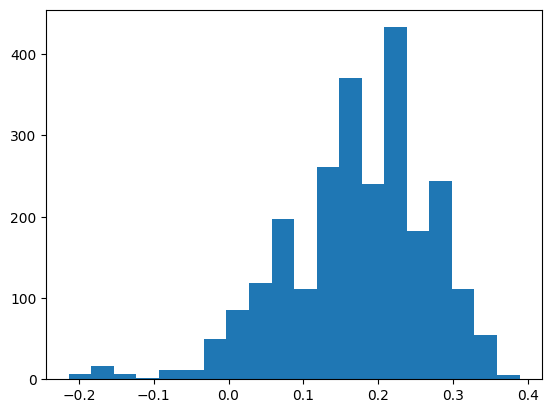

In [670]:
plt.hist(df_gain_mv['Total'].xs('Total', level='delta_bucket'), bins=20)
plt.show()

In [671]:
df_gain_mv.groupby('delta_bucket').mean()

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,-0.091337,-0.117227,-0.129143,-0.267824,-0.363642,-0.038069
0.2,0.090579,0.122563,-1.586282,-0.144384,-1.594128,0.107267
0.3,0.127377,0.110674,0.019210,0.086237,-0.199807,0.115426
0.4,0.147798,0.141777,0.109044,-0.018915,0.110950,0.132007
0.5,0.182326,0.182788,0.186453,0.133011,0.113966,0.173024
0.6,0.176213,0.164060,0.177229,0.154146,0.117386,0.169673
0.7,0.182157,0.194419,0.111494,0.175098,0.215582,0.188407
0.8,0.186529,0.238479,0.163559,0.148929,-1.467170,0.210311
0.9,0.191868,0.202765,-2.166240,-0.289737,-1.918757,0.217022


<Axes: ylabel='delta_bucket'>

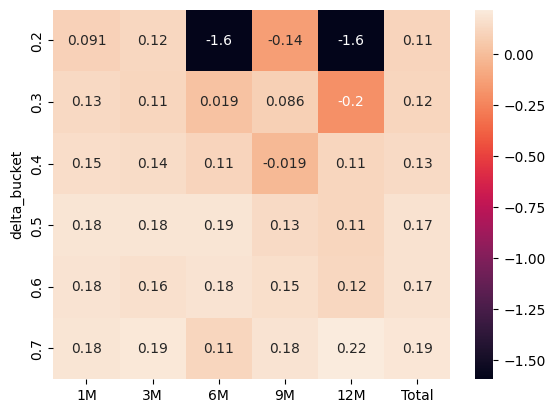

In [403]:
sns.heatmap(df_gain_mv.groupby('delta_bucket').mean().iloc[1:7],annot=True)

<Axes: xlabel='Expiry_Bucket', ylabel='BS_Delta_Bucket'>

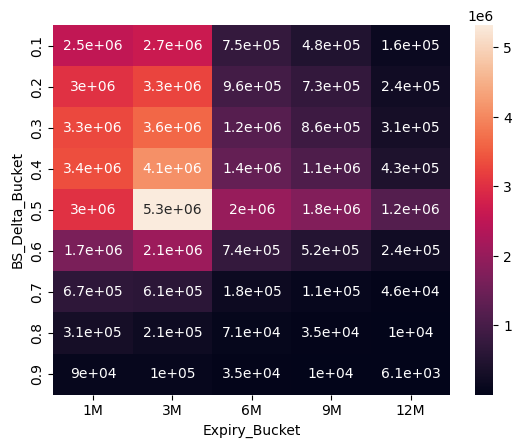

In [672]:
sns.heatmap(df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t0'].sum().unstack(),annot=True)

In [72]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t0'].count().unstack()

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_97140/2605279329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t0'].count().unstack()


Expiry_Bucket,1M,3M,6M,9M,12M
BS_Delta_Bucket,,,,,
0.1,21874,28317,7398,5375,2312
0.2,26125,32245,8604,6134,1987
0.3,29511,37551,10427,6489,2016
0.4,33211,43445,11276,6489,1779
0.5,35677,47428,12665,7790,2387
0.6,29811,32350,6593,3314,795
0.7,21340,18359,2803,1256,237
0.8,12131,8434,1272,421,70
0.9,3901,2644,389,141,19


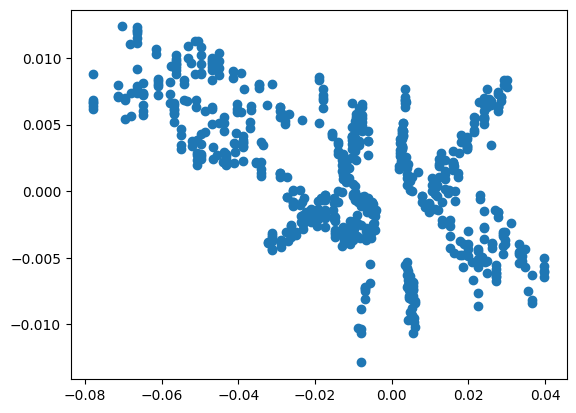

In [73]:
plt.scatter(y=df_calls_diff.loc[testing_period].xs(.5, level='BS_Delta_Bucket').delta_IV,
            x=df_calls_diff.loc[testing_period].xs(.5, level='BS_Delta_Bucket').apply(lambda x: x.delta_S_perc/np.sqrt(x.DTE_t1/360) ,axis=1))

In [74]:
bs_bucket = .2

plt.scatter(y=df_calls_diff.loc[testing_period].xs(bs_bucket, level='BS_Delta_Bucket').delta_IV,
            x=df_calls_diff.loc[testing_period].xs(bs_bucket, level='BS_Delta_Bucket')['delta_S_perc/sqrt_t'])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y=df_calls_diff.loc[testing_period].xs(bs_bucket, level='BS_Delta_Bucket').delta_IV,
                                                                     x=df_calls_diff.loc[testing_period].xs(bs_bucket, level='BS_Delta_Bucket')['delta_S_perc/sqrt_t'])

print(slope)
print(r_value**2)

KeyError: 'delta_S_perc/sqrt_t'

In [75]:
df_calls_diff['delta_S_perc/sqrt_t'] = df_calls_diff['delta_S_perc']/np.sqrt(df_calls_diff['DTE_t0']/360)

In [ ]:
df_calls_diff

In [ ]:
sns.heatmap(df_calls_diff.groupby(['BS_Delta_Bucket','Expiry_Bucket']).count().UNDERLYING_LAST_t1.unstack())

In [ ]:
print(slope, intercept, r_value, p_value, std_err )

In [ ]:
plt.boxplot(df_calls_diff.delta_IV)
plt.plot()

In [ ]:
df_calls_diff.loc[df_calls_diff.delta_IV.idxmax()]

In [ ]:
df_calls_diff.loc[(df_calls_diff['C_BS_t0']-df_calls_diff['C_LAST_t0']).idxmax()]

In [ ]:
plt.boxplot(df_calls_diff['C_BS_t0']-df_calls_diff['C_LAST_t0'])
plt.show()

In [ ]:
df_calls_diff.loc['2019-05-17'].loc[.5]

In [ ]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].count().unstack()

In [ ]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(1).plot(kind='bar')

In [ ]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(0).plot(kind='bar')

In [ ]:
df_calls_diff

In [ ]:
df_gain_mv['Total'].xs('Total', level='delta_bucket')

In [ ]:
(df_calls_diff.loc[testing_period[1:]]
                        .groupby('Expiry_Bucket',
                                observed=True)
                                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

In [ ]:
testing_period[1:]

In [ ]:
testing_period[0]

In [ ]:
df_params

In [ ]:
df_epsilon_bs = (df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

df_epsilon_bs['Total'] = (df_calls_diff.loc[testing_period[1:]]
                            .groupby('BS_Delta_Bucket',
                                    observed=True)
                                    .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

In [ ]:
df_epsilon_bs.loc['Total'] = (df_calls_diff.loc[testing_period[1:]]
                        .groupby('Expiry_Bucket',
                                observed=True)
                                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

In [ ]:
df_calls_diff.loc[testing_period[1:]].apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S)**2,axis=1).sum()

In [ ]:
(pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['Expiry_Bucket'],
                                           observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S
                                                -(x.C_VEGA_t1*100)*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)
                                                )**2)))

In [ ]:
testing_period

In [ ]:
pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )

In [ ]:
plt.hist((pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['BS_Delta_Bucket'],
                                           observed=True)
                        .apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S
                                                -(x.C_VEGA_t1*100)*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)))),bins=30)

In [ ]:
plt.hist((pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['BS_Delta_Bucket'],
                                           observed=True)
                        .apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S
                                                ))),bins=30)

In [ ]:
df_calls_diff.loc[testing_period[1:]]

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_bs

In [ ]:
df_gain_mv

In [ ]:
df_gain_mv.loc[:'2022-01-01'].groupby('delta_bucket')['1M'].mean()

In [ ]:
df_gain_mv['Total'].xs(.6,level='delta_bucket').loc[:'2022-01-01'].head(100).plot()

In [ ]:
df_params.xs('6M', level='expiry_bucket')[['a','minus_b','c']].head(90).plot()

In [ ]:
df_epsilon_mv['Total'] = df_epsilon_mv.sum(1)

In [ ]:
df_epsilon_mv

In [ ]:
df_gain_mv

In [ ]:
len(df_quote_dates)-21*36

In [ ]:
testing_period

In [ ]:
df_gain_mv

In [ ]:
df_gain_mv.fillna(0).groupby('delta_bucket')[df_gain_mv.columns].mean()

In [ ]:
df_gain_mv.head(10)

In [ ]:
(df_calls_diff.loc[testing_period[1:]]
 .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
          observed=True)
 .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)).unstack())

In [ ]:
df_params.loc[testing_period[0],['a','b','c']]

In [ ]:
sse_bs(df_calls_diff.loc[testing_period[1:]],'6M',.5)

In [ ]:
sse_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

In [ ]:
testing_period[1:]

In [ ]:
lists = [
   df_quote_dates.loc[21*36:].values,
   df_calls_diff.index.get_level_values(2).unique().categories
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[21*36:].values, df_quote_dates.loc[:].values)})

In [ ]:
df_calls_diff.index.get_level_values(1).unique()

In [ ]:
i=0
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],
       '6M',
       .5)

In [ ]:
df_gain_mv.loc[testing_period[1]].columns

In [ ]:
len(df_quote_dates)-(21*36+30)

In [ ]:
i = 1000
training_period = df_quote_dates.loc[i:i+21*36].values
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            '6M',
                                                            .5)

In [ ]:
df_gain_mv.xs(.9,level='delta_bucket')['3M'].loc[:'2022-01-01'].mean()

In [ ]:
df_gain_mv.xs(.2,level='delta_bucket')['6M'].loc[:'2022-01-01'].to_frame().min()

In [ ]:
df_gain_mv.loc['2013-10-29']

In [ ]:
df_gain_mv.loc[:'2022-01-01'].groupby('delta_bucket').mean()*100

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_mv.sum(1)

In [ ]:
1-df_epsilon_mv.sum(1)/df_epsilon_bs.sum(1)

In [ ]:
df_quote_dates.loc[933]

In [ ]:
testing_period = (df_quote_dates[(df_quote_dates > '2013-10-29')
               &(df_quote_dates < '2013-12-13')]).to_numpy()

In [ ]:
testing_period

In [ ]:
testing_period[1:]

In [ ]:
df_calls_diff.loc[testing_period[1:]].xs('6M', level='Expiry_Bucket').xs(.2, level='BS_Delta_Bucket')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
testing_period = (df_quote_dates[(df_quote_dates > '2013-10-29')
               &(df_quote_dates < '2013-12-13')]).to_numpy()

df_epsilon_bs = (df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

df_epsilon_mv = (pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                            df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                            left_on = 'Expiry_Bucket',
                            right_on = 'expiry_bucket'
                            )
                            .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                    observed=True)
                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S
                                        -x.C_VEGA_t1*100*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)
                                        )**2))
                .unstack())

df_epsilon_mv = df_epsilon_mv.loc[df_gain_mv.loc[testing_period[1]].index
                                ,df_gain_mv.loc[testing_period[1]].columns]

df_epsilon_bs = df_epsilon_bs.loc[df_gain_mv.loc[testing_period[1]].index
                                ,df_gain_mv.loc[testing_period[1]].columns]


df_gain_mv.loc[testing_period[1]] = (1 - df_epsilon_mv/df_epsilon_bs).values

In [ ]:
df_gain_mv.loc[testing_period[1]]

In [ ]:
(df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket', 'Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_bs

In [ ]:
(1 - df_epsilon_mv/df_epsilon_bs)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[3:]],
                                                            df_params.loc[testing_period[4]],
                                                            '6M',
                                                            .2)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            expiry,
                                                            delta)

In [ ]:
for delta in df_gain_mv.loc[testing_period[1]].index:

    for expiry in df_gain_mv.loc[testing_period[1]].columns:


        try:
            df_gain_mv.loc[testing_period[1], delta][expiry] = gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            expiry,
                                                            delta)
        except:
            
            pass

In [ ]:
3000*2/60

In [ ]:
df_gain_mv.loc[testing_period[1], delta][expiry]

In [ ]:
df_gain_mv.head(10)

In [ ]:
1-45.86514506071337/86.80437565410338

In [ ]:
def sse_helio(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')
    df = df.groupby(['BS_Delta_Bucket'])[['delta_S', 'delta_price', 'UNDERLYING_LAST_t1', 'C_VEGA_t1', 'DTE_t1']].mean()

    print(len(df))

    epsilon_bs = df['delta_price'] - df.index*df['delta_S']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S']/(df['UNDERLYING_LAST_t1']*np.sqrt(df.DTE_t1/360)))*(a+b*df.index+c*(df.index**2))

    return sum(epsilon_mv**2)


for i in range(0, len(df_quote_dates)-21*36):

    testing_period = df_quote_dates.loc[i:i+21*36].values
    training_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

    for expiry in df_params.loc[testing_period[-1]].index:

        result = minimize(fun=sse_helio,
            x0=np.array([0, 0, 0]),
            args=(df_calls_diff.loc[testing_period], expiry),
            method='SLSQP',
            )

        df_params.loc[testing_period[-1]].loc[expiry,['a','b','c']] = result.x

    print(testing_period[-1])



In [ ]:
df_params

In [ ]:
df_calls_diff.loc['2018-4-01':'2019-6-01']

In [ ]:
plt.plot(df_params.xs('3M',level=1)[['a','b','c']])
plt.show()

In [ ]:
df_params.loc[testing_period[-1]].loc['3M'] = result.x

In [ ]:
def sse_mv(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')

    epsilon_bs = df['delta_price_perc'] - df['C_DELTA_t1']*df['delta_S_perc']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S_perc']/(np.sqrt(df.DTE_t1/360)))*(a+b*df['C_DELTA_t1']+c*(df['C_DELTA_t1']**2))

    return sum(epsilon_mv**2)


result = minimize(fun=sse_mv,
         x0=np.array([0, 0, 0]),
         args=(df_calls_diff.loc[testing_period], '3M'),
         method='SLSQP',
         )

print(result)

In [ ]:
a,b,c = result.x

x = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').C_DELTA_t0
y = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').apply(lambda row: row.C_VEGA_t0*100/(row.UNDERLYING_LAST_t0*np.sqrt(row.DTE_t0/360))*(a+b*row.C_DELTA_t0+c*(row.C_DELTA_t0**2)) ,axis=1)
plt.scatter(x=x,y=y)

In [ ]:
a,b,c = result.x

In [ ]:
x = [a+b*x+c*(x**2) for x in df_calls_diff.C_DELTA_t1]*df_calls_diff.delta_S_perc/(np.sqrt(df_calls_diff.DTE_t1/360))
y = df_calls_diff['C_IV_t0'] - df_calls_diff['C_IV_t1']


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data,c='black')

plt.show()

print(f"""Linear Regression - Change in Implied vs Normalized Return: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
plt.boxplot((df_helio['C_IV_t0']-df_helio['C_IV_t1']))
plt.show()

In [ ]:
#Parse data for CALLS

df_calls_data = df_option_data.drop(['P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 
                                     'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV','P_VOLUME'], axis=1)

df_calls_data = df_calls_data[(df_calls_data.C_DELTA < .95)&(df_calls_data.C_DELTA > .05)]
df_calls_data['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_data.C_DELTA]

df_calls_data['Expiry_Bucket'] = pd.cut(df_calls_data.DTE,[14,30,91, 182,365,2000],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

#df_calls_data = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_calls_data.set_index(['EXPIRE_UNIX'])

In [ ]:
df_foo = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket']).loc[(.5,'6M')]

df_foo = df_foo.groupby('QUOTE_DATE')[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE','C_MID','C_BS']].mean()

df_foo['Delta_S'] = df_foo['UNDERLYING_LAST'].diff()/df_foo['UNDERLYING_LAST']
df_foo['Delta_IV'] = df_foo['C_IV'].diff()

df_foo = df_foo.dropna()

x = df_foo['Delta_IV']
y = df_foo['Delta_S']

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Asset Price vs Change in Implied Vol: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

x = (df_foo['UNDERLYING_LAST'].diff()*df_foo['C_DELTA']).dropna()
y = df_foo['C_BS'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
pd.to_datetime('2010-01-08')-pd.to_datetime('2010-04-15')

In [ ]:
df_calls_data.iloc[1000]


In [ ]:
black_scholes(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
bs_delta(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
         K=df_calls_data.iloc[1000].STRIKE,
         sigma=df_calls_data.iloc[1000].C_IV,
         T=df_calls_data.iloc[1000].DTE/360,
         r=-0.01)

In [ ]:
bs_vega(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
df_calls_data = df_calls_data.groupby(['Expiry_Bucket','QUOTE_DATE','BS_Delta_Bucket'])[['UNDERLYING_LAST', 'C_IV', 'C_MID', 'C_DELTA', 'C_VEGA', 'DTE']].mean().copy()
df_calls_data = df_calls_data.dropna()

In [ ]:
df_calls_data

In [ ]:
df_calls_data.index.get_level_values(0).unique().to_list()

In [ ]:
def sse(params):

    total_sse = 0.0

    a = params[0]
    b = params[1]
    c = params[2]

    for expiry in df_calls_data.index.get_level_values(0).unique().to_list():

        delta_f = df_calls_data.xs(expiry).groupby(level=1)['C_MID'].diff()
        delta_s = df_calls_data.xs(expiry).groupby(level=1)['UNDERLYING_LAST'].diff()
        delta_bs = df_calls_data.xs(expiry).groupby(level=1).diff().index.get_level_values(1)
        vega_bs = df_calls_data.xs(expiry)['C_VEGA']*100
        dte = df_calls_data.xs(expiry)['DTE']/360
        underlying = df_calls_data.xs(expiry)['UNDERLYING_LAST']
        
        error_bs = delta_f - delta_bs*delta_s
        error_mv = error_bs - (vega_bs*delta_s/(np.sqrt(dte)*underlying))*(a + b*delta_bs + c*(delta_bs**2))
        error_mv = error_mv.dropna()
    
        total_sse += sum(error_mv**2)
    
    return total_sse


In [ ]:
sse(np.array([0,0,0]))

In [ ]:
df_foo2 = df_calls_data.xs('6M', level=1)

df_foo2 = df_foo2.groupby(['BS_Delta_Bucket','QUOTE_DATE'])[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

list_slopes = []

for delta_bucket in df_foo2.index.get_level_values(0).unique():

    df_loop = df_foo2.loc[delta_bucket]
    df_loop['Delta_S'] = df_loop['UNDERLYING_LAST'].diff()/df_loop['UNDERLYING_LAST']
    
    df_loop['Delta_IV'] = df_loop['C_IV'].diff()

    df_loop = df_loop.dropna()

    x = df_loop['Delta_IV']
    y = df_loop['Delta_S']

    slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
    fitted_data = list(map(fitted_line, x))

    # plt.scatter(x = df_loop['Delta_IV'],
    #             y = df_loop['Delta_S'])

    # plt.plot(x, fitted_data)

    # plt.show()
    list_slopes.append(slope)
    # print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
    #     Slope:{slope}\n
    #     Intercept:{intercept}\n  
    #     R²: {r**2}""")
    
    # print(delta_bucket)


In [ ]:
df_foo2 = df_foo2.reset_index().sort_values(['QUOTE_DATE','BS_Delta_Bucket']).set_index(['QUOTE_DATE','BS_Delta_Bucket'])
quote_dates = df_foo2.index.get_level_values(0).unique()

In [ ]:
def epsilon_mv(df_t0, df_t1, a, b, c):

    available_deltas = list(set(df_t0.index).intersection(df_t1.index))
    df_t0 = df_t0.loc[available_deltas]
    df_t1 = df_t1.loc[available_deltas]

    epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
    epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))
    return epsilon_mv

In [ ]:
epsilon_mv_total = []

for i in range(len(quote_dates)-1):

    epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0).to_list())

SSE = sum([sum(np.array(error)**2) for error in epsilon_mv_total])
print(np.sqrt(SSE))

In [ ]:
quote_dates[i]

In [ ]:
np.sqrt(sum([sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0)**2) for i in range(len(quote_dates)-1)]))

In [ ]:
    
def sse_mv(params):

    a = params[0]
    b = params[1]
    c= params[2]

    epsilon_mv_total = []

    for i in range(len(quote_dates)-1):

        epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=a,b=b,c=c).to_list())

    return sum([sum(np.array(error)**2) for error in epsilon_mv_total])

In [ ]:
result = minimize(fun=sse,
         x0=np.array([0, 0, 0]),
         method='Nelder-Mead',
         )

print(result)

In [ ]:
np.sqrt(sse_mv(result.x))

In [ ]:
df_calls_data

In [ ]:
a,b,c = result.x

y = df_calls_data.xs('2012-12-31',level=1).xs('9M', level=0)
plt.scatter(x=y.index,y=y.index + y.C_VEGA*10/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
(y.C_VEGA/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
c*(y.index**2)

In [ ]:
y = df_option_data.iloc[28364]
print(y.head(20))
print(black_scholes(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0.0))
bs_delta(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0)

In [ ]:
np.sqrt(sse_mv(np.array([-0.2,.4,-.5])))

In [ ]:
np.sqrt(sse(np.array([-3.090e+00, 1.269e+01, -1.925e+01])))

In [ ]:
# for prettier numpy prints
np.set_printoptions(precision = 6)

In [ ]:
sse(np.array([0,0,0]))

In [ ]:
np.sqrt(sse(result.x))

In [ ]:
call

In [ ]:
result.x

In [ ]:
np.sqrt(sse([0,0,0]))

In [ ]:
df_calls_data

In [ ]:
[i/np.sqrt(360) for i in [-3.400e+00 ,1.478e+01, -2.341e+01]]

In [ ]:
quote_dates

In [ ]:
df_foo2.loc[quote_dates[i-1]].index

In [ ]:
list(set(df_foo2.loc[quote_dates[i-1]].index).intersection(df_foo2.loc[quote_dates[i]].index))

In [ ]:
sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.0,b=0,c=0)**2)

In [ ]:
epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.05,b=0,c=-.6).to_list()

In [ ]:
quote_dates[i-1]

In [ ]:
df_t0

In [ ]:
a,b,c=0,0,0
i=30
df_t0 = df_foo2.loc[quote_dates[i]]
df_t1 = df_foo2.loc[quote_dates[i-1]]

available_deltas = list(set(df_t0.index).intersection(df_t1.index))
df_t0 = df_t0.loc[available_deltas]
df_t1 = df_t1.loc[available_deltas]

epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
(df_t0.C_LAST-df_t1.C_LAST)

In [ ]:
df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)

In [ ]:
sum(epsilon_bs**2)

In [ ]:
a=.0
((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
df_t0.UNDERLYING_LAST

In [ ]:
df_foo2.loc[quote_dates[i-1]]

In [ ]:
df_foo2.loc[quote_dates[i],['C_LAST', 'C_BID', 'C_ASK']]

In [ ]:
plt.plot((df_foo2.loc['2010-01-05'].C_LAST-df_foo2.loc['2010-01-06'].C_LAST)-(df_foo2.loc['2010-01-05'].UNDERLYING_LAST-df_foo2.loc['2010-01-06'].UNDERLYING_LAST)*df_foo2.loc['2010-01-05'].C_DELTA)

In [ ]:
df_foo2.index.get_level_values(0).unique()

In [ ]:
list_slopes = np.sqrt(df_foo2.groupby('BS_Delta_Bucket')['DTE'].mean().values/360)*list_slopes

x = df_foo2.index.get_level_values(0).unique()
y = list_slopes

model = np.poly1d(np.polyfit(x, y, 2))

#add fitted polynomial line to scatterplot
plt.scatter(x, y)
plt.plot(x, model(x))

print(model)
plt.show()



In [ ]:
for i in df_foo2.index.get_level_values(0).unique():

    df_foo2.loc[i]

In [ ]:
df_foo2.loc[.5].C_LAST.diff().plot()

In [ ]:
plt.plot(df_foo2.loc[i].C_DELTA)

In [ ]:
i=.5
plt.plot(df_foo2.loc[i].UNDERLYING_LAST.diff()*df_foo2.loc[i].C_DELTA)
plt.plot(df_foo2.loc[i].C_LAST.diff())

In [ ]:
df_foo2.loc[i].C_LAST.diff()

In [ ]:
y

#### $ \Delta f - \delta_{bs}\Delta S = \frac{\nu_{bs}}{\sqrt{T}}\frac{\Delta S}{S}(a+b\delta_{bs}+\delta^{2}_{bs}) $

In [ ]:
df_foo2.loc[i,'UNDERLYING_LAST'].diff()*df_foo2.loc[i,'C_VEGA']/(np.sqrt(df_foo2.loc[i,'DTE'])*df_foo2.loc[i,'UNDERLYING_LAST'])

In [ ]:
x = (df_foo2.loc[i]['UNDERLYING_LAST'].diff()*df_foo2.loc[i]['C_DELTA']).dropna()
y = df_foo2.loc[i]['C_LAST'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x-y).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)